In [1]:
from typing import Union
from pathlib import Path
import os
import copy
from joblib import Parallel, delayed
from tqdm import tqdm
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import string
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import gaussian_kde, kstest
import src
from src.catalogs import (
    JapanSlowSlipCatalog,
    MexicoSlowSlipCatalog, 
    CostaRicaSlowSlipCatalog,
    WilliamsSlowSlipCatalog,
    MichelSlowSlipCatalog,
    OkadaAlaskaSlowSlipCatalog,
)
from src.data import (
    AllSlabs, 
    Catalog,
    EarthquakeCatalog,
    Scaling,
)

base_dir = Path(src.__file__).parents[1]

dpi = 200
mpl.rc('figure',dpi=dpi)
plt.style.use('tableau-colorblind10')
mpl.rc('font',size=9)

# passed to src.savefig
save_figures = True
new_directory = True
figure_base_dir = base_dir/'Docs'/'Paper_draft'/'Figures'

if new_directory:
    counter = 0
    new_figure_base_dir = figure_base_dir  # Create a new variable to store the modified path
    while new_figure_base_dir.exists():
        counter += 1
        new_figure_base_dir = Path(str(figure_base_dir) + f'_v{counter}')

    os.makedirs(new_figure_base_dir)
    figure_base_dir = new_figure_base_dir

# Global analysis of subduction slow slip events and their association with earthquakes

### Kélian Dascher-Cousineau, Roland Bürgmann

University of California Berkeley, Miller Institute for Basic Science

## Configurable parameters

In [2]:

EARTHQUAKE_MAGNITUDE_CUTOFF = 4.0  # minimum earthquake magntitude
assert EARTHQUAKE_MAGNITUDE_CUTOFF >= 3.5

DEPTH_SUBSET = 'all'                
# depth subsets selected in clusters using k-means. The number of clusters for each region was selected by visual inspection.
assert DEPTH_SUBSET in ['deep','shallow','all']

DURATION_SUBSET = 'all'
assert DURATION_SUBSET in ['short term', 'long term', 'all']

SLOWSLIP_MAGNITUDE_CUTOFF = 5.8     # minimum slow slip event magntitude

# Duplicate filtering
DUPLICATE_RADIUS = 70               # km
DUPLICATE_TIME = 40                 # days

# Spatio-temporal emporal analysis:
TIME_WINDOW = 13                    # source durations (e.g. 7 background, 1 coshocks, 7 aftershock)
SMOOTHING_BW_SOURCE_DURATION = 0.2  # source durations 

SPACE_WINDOW_BIG = 2000             # km for spatial stack
DISTANCE_TO_SLAB = 20               # km (slab perpendicular distance to Slab 2.0 model for windows)

IMPUTE_DURATION = True              # add durations based on best fit to magnitude/duration scaling
REPRESENTATIVE_SSE_SIZE = 50        # km for temporal stack

BACKGROUND_DURATION = (TIME_WINDOW-1)/2 # source durations

# Sensitivity tests and benchmarks:
NEARBY_EQ_DISTANCE = 20

## Datasets

`AllSlabs` loads in all the slab geometries from Slab2.0

`EarthquakeCatalog` loads the global Comcat catalog. The first time running this will take a long time (a few minutes).

In [3]:
all_slabs = AllSlabs()

earquake_metadata = {
    "starttime": '1990-01-01',
    "endtime": '2023-01-01',
    "latitude_range": [-90,90],
    "longitude_range": [-180,180],
    "minimum_magnitude": 3.5, 
}

# If running for the first time, or if the metadata is changed, this downloads the global catalog
# ...which can take a while
earthquakes = EarthquakeCatalog(
    filename=base_dir / "Datasets" / "Seismicity_datasets" / "global_earthquakes_35.csv",
    kwargs=earquake_metadata,
)
earthquakes.mag_completeness = EARTHQUAKE_MAGNITUDE_CUTOFF
# Expect two warnings:
# if reloading an existing catalog
# removing NaN values from downloaded catalog

/Users/kdascher/Documents/Documents - Kelian’s MacBook Pro/Projects/Slow_slip_meta_analysis/src/data/earthquake.py:179: UserWarning: Using existing /Users/kdascher/Documents/Documents - Kelian’s MacBook Pro/Projects/Slow_slip_meta_analysis/Datasets/Seismicity_datasets/global_earthquakes_35.csv
  warnings.warn(f"Using existing {filename}")
/Users/kdascher/Documents/Documents - Kelian’s MacBook Pro/Projects/Slow_slip_meta_analysis/src/data/earthquake.py:185: UserWarning: 996 NaN values found in catalog. Removing rows with NaN values.
  warnings.warn(


In [4]:
analysis_metadata = {
    "slow slip events":{
        "depth": DEPTH_SUBSET,
        "duration": DURATION_SUBSET,
        "minimum magnitude": SLOWSLIP_MAGNITUDE_CUTOFF,
        "duplicates": {
            "radius": DUPLICATE_RADIUS,
            "time": DUPLICATE_TIME
        },
        "impute duration": True,
        "representative size": REPRESENTATIVE_SSE_SIZE,
    },
    "earthquakes":earquake_metadata,
    "background_duration": BACKGROUND_DURATION,
    "nearby earthquake distance": NEARBY_EQ_DISTANCE,
}

def savefig(figname, kwargs=None): 
    return src.savefig(
    figname, 
    save_figures, 
    figure_base_dir,
    metadata=analysis_metadata,
    figure_kwargs=kwargs,
)

## Slow slip datasets and pre-processing

In [5]:
# Consider depth subsets THIS CURRENTLY RELOADS THE DATA!!
if DEPTH_SUBSET == 'shallow':
    shallow_slowslip = [
        JapanSlowSlipCatalog().get_ryukyu_trench().get_clusters('depth',2)[0],
        JapanSlowSlipCatalog().get_japan_trench().get_clusters('depth',2)[0],
        JapanSlowSlipCatalog().get_boso_peninsula().get_clusters('depth',2)[0],
        CostaRicaSlowSlipCatalog().get_clusters('depth',2)[0],
        WilliamsSlowSlipCatalog().get_clusters('depth',2)[0],
    ]

    slowslip = shallow_slowslip

elif DEPTH_SUBSET == 'deep':
    deep_slowslip = [
        JapanSlowSlipCatalog().get_nankai_trough().get_clusters('depth',2)[1],
        JapanSlowSlipCatalog().get_ryukyu_trench().get_clusters('depth',2)[1],
        JapanSlowSlipCatalog().get_japan_trench().get_clusters('depth',2)[1],
        JapanSlowSlipCatalog().get_boso_peninsula().get_clusters('depth',2)[1],
        MexicoSlowSlipCatalog(), 
        CostaRicaSlowSlipCatalog().get_clusters('depth',2)[1],
        WilliamsSlowSlipCatalog().get_clusters('depth',2)[1],
        MichelSlowSlipCatalog(),
        OkadaAlaskaSlowSlipCatalog().get_clusters('depth',2)[1],
    ]
    
    slowslip = deep_slowslip

elif DEPTH_SUBSET == 'all':
    slowslip = [
        JapanSlowSlipCatalog().get_nankai_trough(),
        JapanSlowSlipCatalog().get_ryukyu_trench(),
        JapanSlowSlipCatalog().get_japan_trench(),
        JapanSlowSlipCatalog().get_boso_peninsula(),
        MexicoSlowSlipCatalog(), 
        CostaRicaSlowSlipCatalog(),
        WilliamsSlowSlipCatalog(),
        MichelSlowSlipCatalog(),
        OkadaAlaskaSlowSlipCatalog(),
    ]
        
# Consider magnitude cutoff
for ss in slowslip:
    ss.mag_completeness = SLOWSLIP_MAGNITUDE_CUTOFF # changing in place

# Consider different duration types of SSEs
if DURATION_SUBSET == 'short term':
    slowslip = [ss.get_short_term_events() for ss in slowslip]
elif DURATION_SUBSET == 'long term':
    slowslip = [ss.get_long_term_events() for ss in slowslip] 

slowslip = [ss for ss in slowslip if len(ss)>0]
all_slowslip = sum(slowslip[1:], slowslip[0])

# Consider unique events
filter_kwargs = dict(
    buffer_radius_km = DUPLICATE_RADIUS,
    buffer_time_days = DUPLICATE_TIME,
    stategy='reference',
)

all_slowslip = all_slowslip.filter_duplicates(
    **filter_kwargs,
    ref_preference = all_slowslip.catalog.groupby('ref').max().time.sort_values(ascending=False).index
)

slowslip_filtered = []
for s in slowslip:
    slowslip_filtered.append(s.filter_duplicates(**filter_kwargs, ref_preference=s.catalog.groupby('ref').max().time.sort_values(ascending=False).index))

slowslip = slowslip_filtered
slowslip = sorted(slowslip, key=lambda x: len(x), reverse=True)
for s in slowslip:
    s.catalog['name'] = s.name 
    s.catalog['region'] = s.region
all_slowslip = sum(slowslip[1:], slowslip[0])

# Impute durations:
if IMPUTE_DURATION is True:
    for ss in slowslip: 
        ss.impute_duration(
            mag=all_slowslip.catalog.mag,
            duration=all_slowslip.catalog.duration,
        )
    all_slowslip.impute_duration()
            

/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_99076/1831067542.py:63: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  ref_preference = all_slowslip.catalog.groupby('ref').max().time.sort_values(ascending=False).index
/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_99076/1831067542.py:68: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  slowslip_filtered.append(s.filter_duplicates(**filter_kwargs, ref_preference=s.catalog.groupby('ref').max().time.sort_values(ascending=False).index))


In [6]:
all_slowslip.catalog.ref.sort_values().value_counts(sort=False)

Chen et al. (2018)              3
Cruz-Atienza et al. (2021)      7
El Yousfi et al. (2022)         2
Graham et al. (2016)            6
Itaba et al. (2013a)            2
Itaba et al. (2014a)            4
Itaba et al. (2015)             2
Ito et al. (2013)               2
Kostoglodov (2003)              1
Lou et al. in prep.            12
Lowry et al. (2001)             1
Michel et al. 2018             27
Nishimura (2013)               32
Nishimura (2014)              160
Nishimura (2021)              126
Ochi et al. (2015)              3
Ochi et al. (2016)              1
Okada et al. (2022)           193
Okada et al. (2023)            51
Perry et al. (2023)             4
Radiguet et al. (2011)          1
Radiguet et al. (2016)          1
Rousset et al. 2017            27
Sekine et al. (2010)            1
Takagi et al. (2016)            3
Takagi et al. (2022)           19
Williams et al., in prep.      53
Xie et al. (2020)               8
Yano and Kano (2022)            5
Name: ref, dty

In [7]:
df = all_slowslip.catalog
grouped_df = df.groupby('ref')['region'].agg(['count', lambda x: x.mode().tolist()]).reset_index()

# Rename the columns for clarity
grouped_df.columns = ['ref', 'count', 'Region']
display(grouped_df)

,ref,count,Region
0,Chen et al. (2018),3,[Ryukyu Trench]
1,Cruz-Atienza et al. (2021),7,[Mexico]
2,El Yousfi et al. (2022),2,[Mexico]
3,Graham et al. (2016),6,[Mexico]
4,Itaba et al. (2013a),2,[Nankai Trough]
5,Itaba et al. (2014a),4,[Nankai Trough]
6,Itaba et al. (2015),2,[Nankai Trough]
7,Ito et al. (2013),2,[Japan Trench]
8,Kostoglodov (2003),1,[Mexico]
9,Lou et al. in prep.,12,[Japan Trench]


Chen et al. (2018)              3
Cruz-Atienza et al. (2021)      7
El Yousfi et al. (2022)         2
Graham et al. (2016)            6
Itaba et al. (2013a)            2
Itaba et al. (2014a)            4
Itaba et al. (2015)             2
Ito et al. (2013)               2
Kostoglodov (2003)              1
Lou et al. in prep.            12
Lowry et al. (2001)             1
Michel et al. 2018             27
Nishimura (2013)               32
Nishimura (2014)              160
Nishimura (2021)              126
Ochi et al. (2015)              3
Ochi et al. (2016)              1
Okada et al. (2022)           193
Okada et al. (2023)            51
Perry et al. (2023)             4
Radiguet et al. (2011)          1
Radiguet et al. (2016)          1
Rousset et al. 2017            27
Sekine et al. (2010)            1
Takagi et al. (2016)            3
Takagi et al. (2022)           19
Williams et al., in prep.      53
Xie et al. (2020)               8
Yano and Kano (2022)            5
Name: ref, dty

[None, None, None]

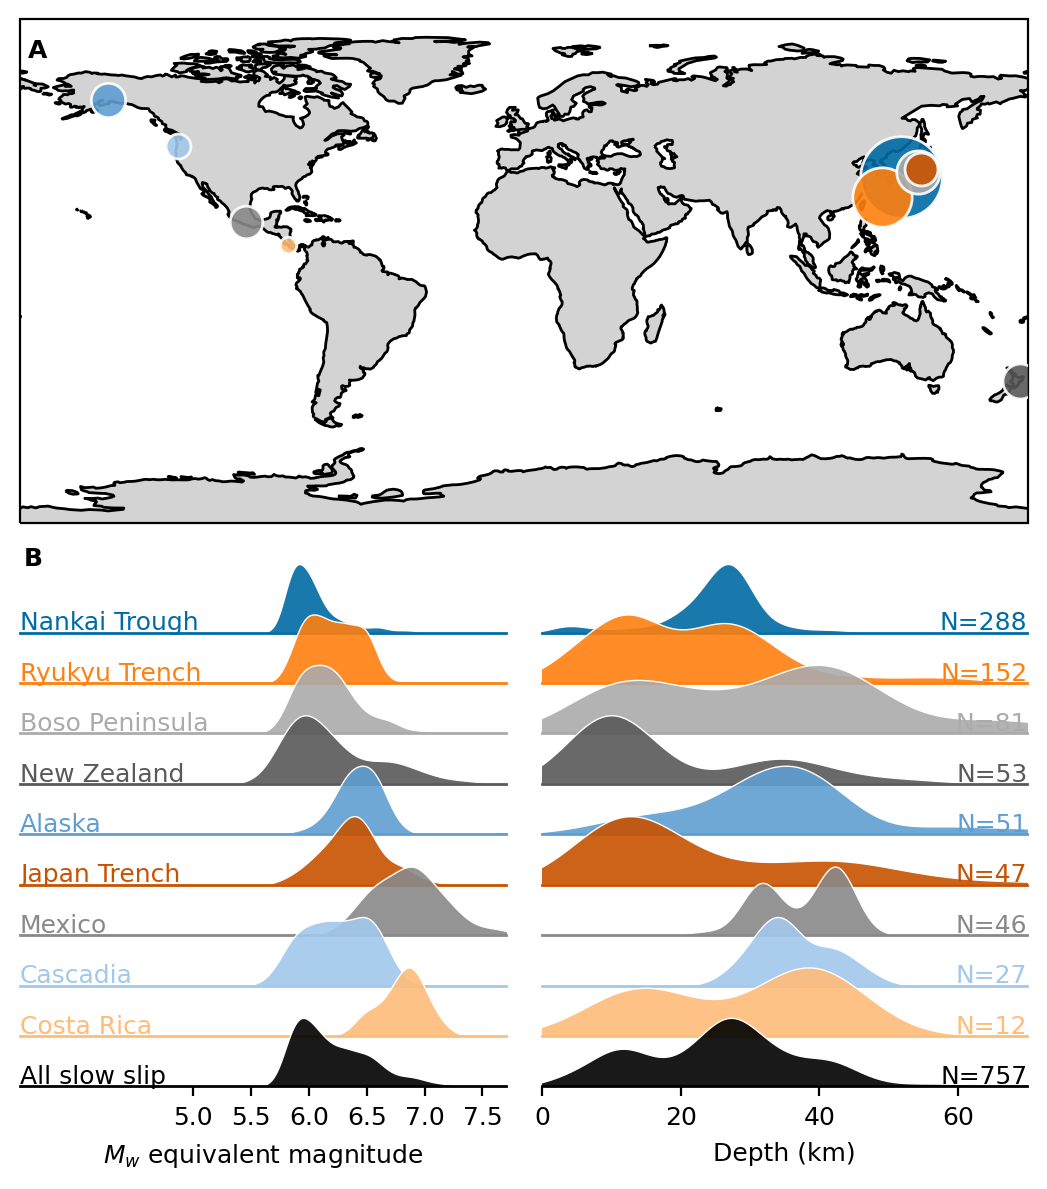

In [8]:
fig = plt.figure(figsize=(6.5,7))

gs0 = mpl.gridspec.GridSpec(2, 1,  hspace=0.05)

# Map:
ax0 = fig.add_subplot(gs0[0], projection=ccrs.PlateCarree())
extent = [-180,180,-90,90]
ax0.set_extent(extent,crs=ccrs.PlateCarree(),)
ax0.add_feature(cfeature.LAND, color="lightgray")
# ax0.add_feature(cfeature.OCEAN)
ax0.add_feature(cfeature.COASTLINE)

for i_slowslip in slowslip:
    ax0.scatter(
        np.mean(i_slowslip.catalog.lon),
        np.mean(i_slowslip.catalog.lat),
        s=len(i_slowslip)*3,
        edgecolor='w',
        label=f"N={len(i_slowslip)}, {i_slowslip.region}",
        zorder=10,
        alpha=0.9
    )

# Two colomns of ridgelin plots:
gs01 = mpl.gridspec.GridSpecFromSubplotSpec(len(slowslip)+1, 2, subplot_spec=gs0[1], hspace=-0.3, wspace=0.075)

def clean_ax(ax):
    ax.set(
        yticks=[],
        xticks=[],
        ylabel='',
        xlabel='',
        xticklabels=[],
    )
    rect = ax.patch
    rect.set_alpha(0)
    spines = ["top","right","left","bottom"]
    for s in spines:
        ax.spines[s].set_visible(False)

mag_AX = []
depth_AX = []
for i,ss in enumerate(slowslip+[all_slowslip]):
    shared_kwargs = dict(
        data=ss.catalog,
        color=f"C{i}" if i<len(slowslip) else 'k',
        linewidth=0.5,
        edgecolor='w',
        alpha=0.9,
        clip_on=True,
        fill=True,
    )

    mag_AX.append(fig.add_subplot(gs01[i, 0]))
    ax = mag_AX[-1]
    
    sns.kdeplot(
        x='mag',
        **shared_kwargs,
        ax=ax,
    )
    ax.axhline(0, color=f"C{i}" if i<len(slowslip) else 'k',lw=1, clip_on=False)

    ax.set_xlim(3.5,max(all_slowslip.catalog.mag))

    
    depth_AX.append(fig.add_subplot(gs01[i, 1]))
    ax = depth_AX[-1]
    
    sns.kdeplot(
        x='depth',
        ax=ax,
        **shared_kwargs,
    )
    ax.axhline(0, color=f"C{i}" if i<len(slowslip) else 'k',lw=1, clip_on=False)
    ax.set_xlim(0,70)
    
    [clean_ax(ax) for ax in [mag_AX[-1], depth_AX[-1]]]    


for i in range(len(slowslip)+1):
    ax = mag_AX[i]
    ax.text(
        0, 
        0.04, 
        slowslip[i].region if i<len(slowslip) else 'All slow slip', 
        color=ax.lines[-1].get_color() if i<len(slowslip) else 'k',
        transform=ax.transAxes, 
        ha='left'
    )
    
    ax = depth_AX[i]
    ax.text(        
        1, 
        0.04,
        f"N={len(slowslip[i])}" if i<len(slowslip) else f"N={len(all_slowslip)}",
        color=ax.lines[-1].get_color() if i<len(slowslip) else 'k',
        transform=ax.transAxes, 
        ha='right'
    )
    
ax = depth_AX[-1]
xticks = [0,20,40,60]
ax.set(xticks=xticks, xticklabels=xticks, xlabel='Depth (km)')

ax = mag_AX[-1]
xticks = np.arange(5,8,0.5)
ax.set(xticks=xticks, xticklabels=xticks, xlabel='$M_w$ equivalent magnitude')

for n, ax in enumerate([ax0,mag_AX[0]]):
    pos = [0.008, 0.925]
    ax.text(*pos, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')

savefig('global_map')

print(all_slowslip.catalog.ref.sort_values().value_counts(sort=False))

print("\nDepth clusters (km):")
[print(np.mean(c.catalog.depth)) for c in all_slowslip.get_clusters('depth',3)]

Cruz-Atienza et al. (2021)      7
El Yousfi et al. (2022)         3
Graham et al. (2016)            6
Itaba et al. (2013a)            7
Itaba et al. (2013b)            1
Itaba et al. (2014a)            3
Itaba et al. (2014b)            5
Itaba et al. (2015)             2
Kitagawa et al. (2011)          2
Kitagawa et al. (2012)          2
Kostoglodov (2003)              1
Lou et al. in prep.            14
Lowry et al. (2001)             1
Michel et al. 2018             64
Nishimura (2013)               31
Nishimura (2014)               74
Nishimura (2021)               66
Ochi et al. (2015)              6
Ochi et al. (2016)              4
Okada et al. (2022)           196
Okada et al. (2023)             5
Radiguet et al. (2011)          1
Radiguet et al. (2016)          1
Rousset et al. 2017            27
Sekine et al. (2010)            2
Takagi et al. (2016)            1
Takagi et al. (2022)            5
Williams et al., in prep.      18
Xie et al. (2020)               7
Yano and Kano (2022)            4

In [9]:
def bootstrap_ci(df,col,stat_fun=np.mean, ci=0.95,n=10000):
    assert ci <= 1
    stat = []
    for _ in range(n):
        stat.append(
            stat_fun(
                df[col].sample(len(df),replace=True).values
            )
        )
    return np.quantile(stat, [0.5-ci/2, 0.5+ci/2])

mean_mag = all_slowslip.catalog.mag.mean()
ci = bootstrap_ci(all_slowslip.catalog,'mag')

print(f"Slow slip event magnitude is {mean_mag} +/- {ci-mean_mag}")

Slow slip event magnitude is 6.215768871746855 +/- [-0.0227195  0.0238123]


Start time: 1994-12-01 00:00:00
End time: 2022-04-24 03:35:59.999998


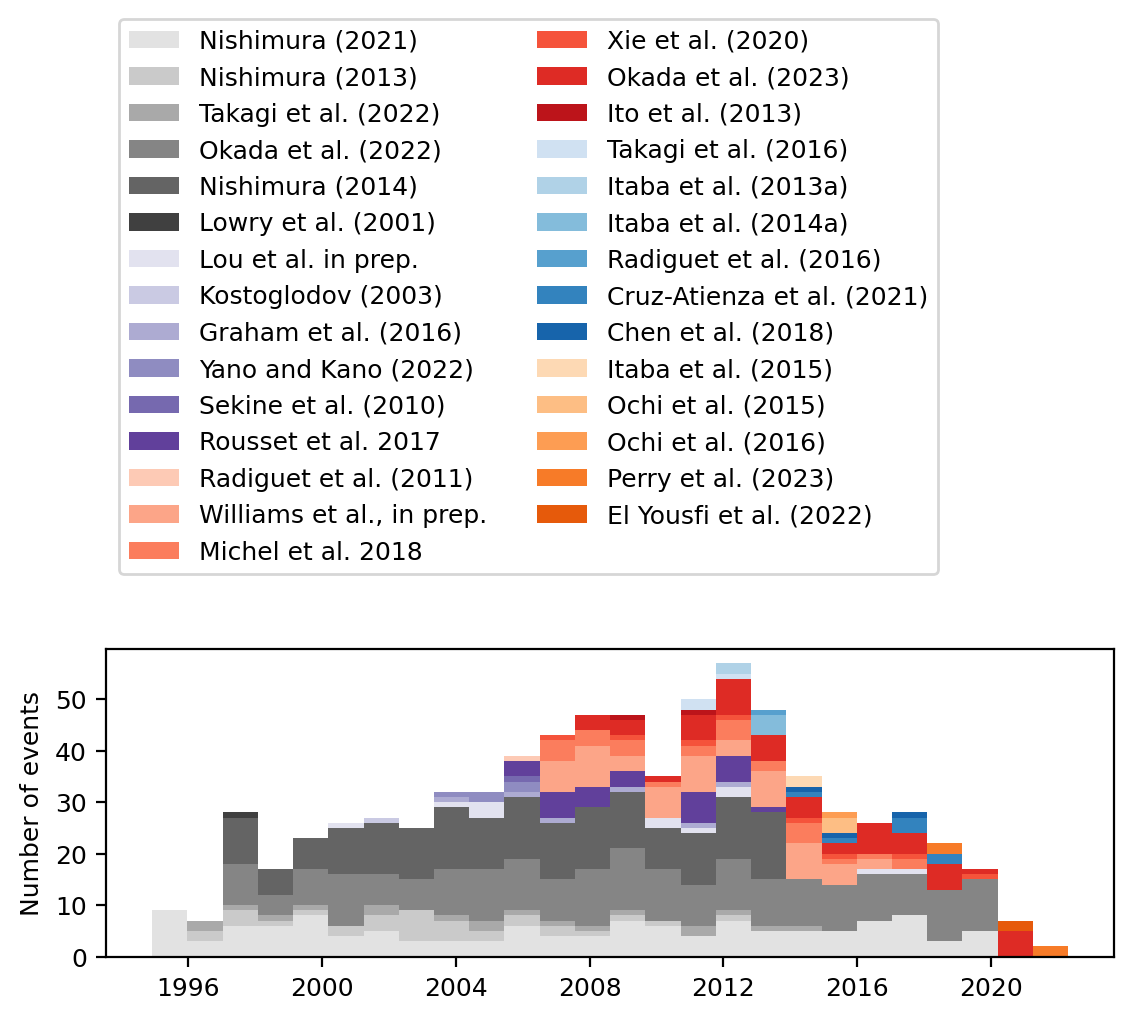

In [10]:
print('Start time:', all_slowslip.start_time)
print('End time:', all_slowslip.end_time)

fig, ax = plt.subplots(figsize=(6.5,2))
times_by_study = [
    all_slowslip.catalog.time[all_slowslip.catalog.ref==iref].values 
    for iref in all_slowslip.catalog.ref.unique()
]

N = 6 # number of colors to extract from each of the base_cmaps below
base_cmaps = ['Greys','Purples','Reds','Blues','Oranges','Greens']

n_base = len(base_cmaps)
# we go from 0.2 to 0.8 below to avoid having several whites and blacks in the resulting cmaps
colors = np.concatenate([plt.get_cmap(name)(np.linspace(0.2,0.8,N)) for name in base_cmaps])
cmap = mpl.colors.ListedColormap(colors)

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

ax.hist(times_by_study,bins=26, histtype='barstacked',label=all_slowslip.catalog.ref.unique(),color=[cmap.colors[i] for i in range(len(times_by_study))])
ax.set(
    ylabel='Number of events'
)
ax.legend(ncol=2, bbox_to_anchor=(0., 1.2, 1, 1))
savefig('global_catalog_time_coverage')


## Analysis

In [11]:
local_earthquakes = earthquakes.intersection(all_slowslip,buffer_radius_km=SPACE_WINDOW_BIG)
distance_to_slab = all_slabs.distance(
    local_earthquakes.catalog[["lat","lon","depth"]].values,
    depth_unit="km",
    distance_unit="km",
)
local_earthquakes = EarthquakeCatalog(local_earthquakes.catalog.loc[distance_to_slab < DISTANCE_TO_SLAB])

/Users/kdascher/Documents/Documents - Kelian’s MacBook Pro/Projects/Slow_slip_meta_analysis/src/data/slab2.py:138: UserWarning: xyz contains negative depths
  warnings.warn("xyz contains negative depths")


## Global stacking

### Time stacks

In [12]:
def center_sequences(
    slowslipevents: Catalog = all_slowslip,
    earthquakes: Catalog = local_earthquakes,
    time_window: Union[float,np.ndarray] = TIME_WINDOW,
    space_window: float = REPRESENTATIVE_SSE_SIZE,
    lag = 0,
    slab_model=all_slabs,
    concatenate_output: bool = True,
    return_indices: bool = False,
    use_durations: bool = True,
    use_dimensions: bool = True,
):
        
    return src.center_sequences(
        slowslipevents=slowslipevents,
        earthquakes=earthquakes,
        time_window=time_window,
        space_window=space_window,
        lag=lag,
        slab_model=slab_model,
        concatenate_output=concatenate_output,
        return_indices=return_indices,
        use_durations = use_durations,
        use_dimensions= use_dimensions,
    )

Propotion of M6.0 within 20 km from SSEs and 100 days: 55.125


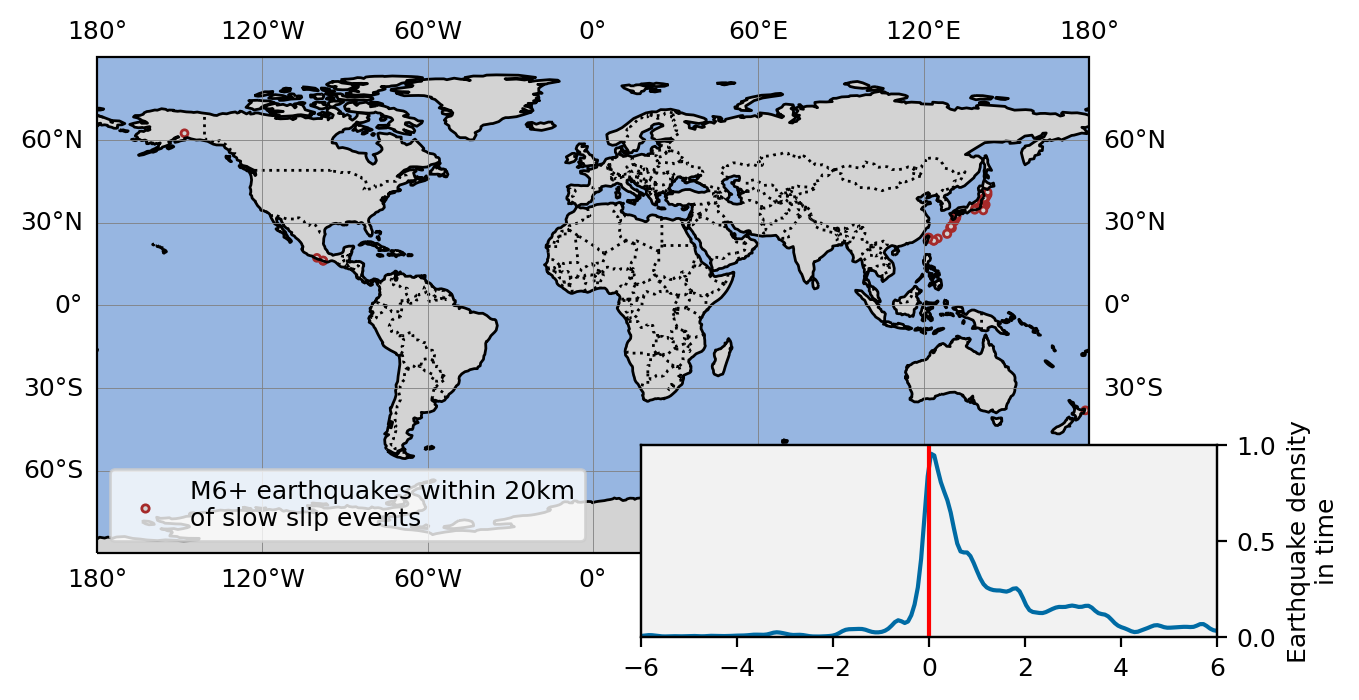

In [13]:
distance=NEARBY_EQ_DISTANCE
very_local_earthquakes =  earthquakes.intersection(all_slowslip,buffer_radius_km=distance)
distance_to_slab = all_slabs.distance(
    very_local_earthquakes.catalog[["lat","lon","depth"]].values,
    depth_unit="km",
    distance_unit="km",
)
very_local_earthquakes = EarthquakeCatalog(very_local_earthquakes.catalog.loc[distance_to_slab < DISTANCE_TO_SLAB])
big_local_earthquake_min_mag = 6
big_local_earthquakes = very_local_earthquakes.slice_by('mag',big_local_earthquake_min_mag)
dt, dx, w = center_sequences(slowslipevents=big_local_earthquakes, use_durations=False)


ax = big_local_earthquakes.plot_map()
ax.set(xlim=[-180,180],ylim=[-90,90])
ax.legend([f'M{big_local_earthquake_min_mag}+ earthquakes within {NEARBY_EQ_DISTANCE}km\nof slow slip events'],loc='lower left')

left, bottom, width, height = [0.55, 0.15, 0.45, 0.2]
ax2 = plt.gcf().add_axes([left, bottom, width, height])
axb = ax2.twinx() 
sns.kdeplot(dt,ax=ax2, bw_adjust=0.3)
axb.axvline(c='r')
axb.set(
    xlabel='Time after earthquake (days)',
    ylabel='Earthquake density\nin time',
    xlim=[-(TIME_WINDOW-1)/2, (TIME_WINDOW-1)/2]
)
ax2.set(yticks=[], ylabel=None)
ax2.set_facecolor((0.95,0.95,0.95))
savefig('nearby_earthquake')

print(f'Propotion of M{big_local_earthquakes.mag_completeness} within {distance} km from SSEs and 100 days: {len(dt)/len(big_local_earthquakes)}')


## Temporal stacking

In [14]:
# lazy way of doing this...
raw_global_relative_times, raw_global_relative_distances, raw_global_weights, raw_global_Indices = center_sequences(
    time_window=TIME_WINDOW, concatenate_output=False, return_indices=True
)

global_relative_times, global_relative_distances, global_weights = center_sequences(
    time_window=TIME_WINDOW
)

regional_relative_times = []
regional_relative_distances = []
regional_weights = []
regionalized_weights = []
regional_window_indices = []

for region in slowslip:
    dt, dx, w, I = center_sequences(region,time_window=TIME_WINDOW, return_indices=True)
    regional_relative_times.append(dt)
    regional_relative_distances.append(dx)
    regional_weights.append(w)
    regionalized_weights.append(w/len(w))
    regional_window_indices.append(I)
    
combined_regional_relative_times = np.concatenate(regional_relative_times)
regionalized_weights = np.concatenate(regionalized_weights)
    

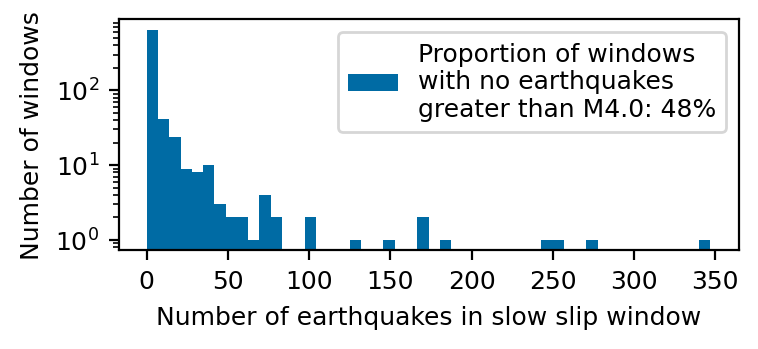

In [15]:
fig, ax = plt.subplots(figsize=(4,1.5))
counts = np.array([len(s) for s in raw_global_relative_times])
ax.hist(
    counts, 
    log=True, 
    bins=50, 
    label=f'Proportion of windows\nwith no earthquakes\ngreater than M{EARTHQUAKE_MAGNITUDE_CUTOFF}: {np.mean(counts==0)*100:.0f}%'
)
ax.set(
    xlabel='Number of earthquakes in slow slip window',
    ylabel='Number of windows',
)
ax.legend()
savefig('Number_of_earthquakes_in_windows')


In [16]:
data_std = np.std(global_relative_times)
bw = SMOOTHING_BW_SOURCE_DURATION/data_std

number_of_times = 1000
time_array = np.linspace(-(0.8*TIME_WINDOW)/2, (0.8*TIME_WINDOW)/2, number_of_times)

dens_co_kde = gaussian_kde(global_relative_times, bw_method=bw, weights=global_weights)
dens_co_normalized = dens_co_kde(time_array)*TIME_WINDOW

regional_jackknife = []
for i in range(len(slowslip)):
    i_slowslip = [sse for n,sse in enumerate(slowslip) if n != i] # all but the ith slow slip event
    dt, dx, w = center_sequences(sum(i_slowslip[1:],i_slowslip[0]),time_window=TIME_WINDOW)
    regional_jackknife.append(
        gaussian_kde(dt, bw_method=bw, weights=w)(time_array)*TIME_WINDOW
    )
    
regional_dens = []
for dt,w in zip(regional_relative_times, regional_weights):
    regional_dens.append(
        gaussian_kde(dt, bw_method=bw, weights=w)(time_array)*TIME_WINDOW
    )

In [17]:
def sample_random_times(_):
    sse_copy = copy.deepcopy(all_slowslip)
    sse_copy.catalog['time'] = np.random.random(len(sse_copy)) * sse_copy.duration + sse_copy.start_time
    i_relative_times, _, i_weights = center_sequences(
        slowslipevents=sse_copy,time_window=TIME_WINDOW,
    )
    data_std = np.std(i_relative_times)
    bw = SMOOTHING_BW_SOURCE_DURATION/data_std
    i_dens_co_kde = gaussian_kde(i_relative_times, bw_method=bw, weights=i_weights)
    i_dens_co_normalized = i_dens_co_kde(time_array)*TIME_WINDOW
    return i_dens_co_normalized

number_of_random_samples = 10000
random_ts = Parallel(n_jobs=-1)(delayed(sample_random_times)(i) for i in tqdm(range(number_of_random_samples)))

  4%|▍         | 420/10000 [02:10<40:13,  3.97it/s] /Users/kdascher/miniforge3/envs/torchETAS/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
100%|██████████| 10000/10000 [48:12<00:00,  3.46it/s]


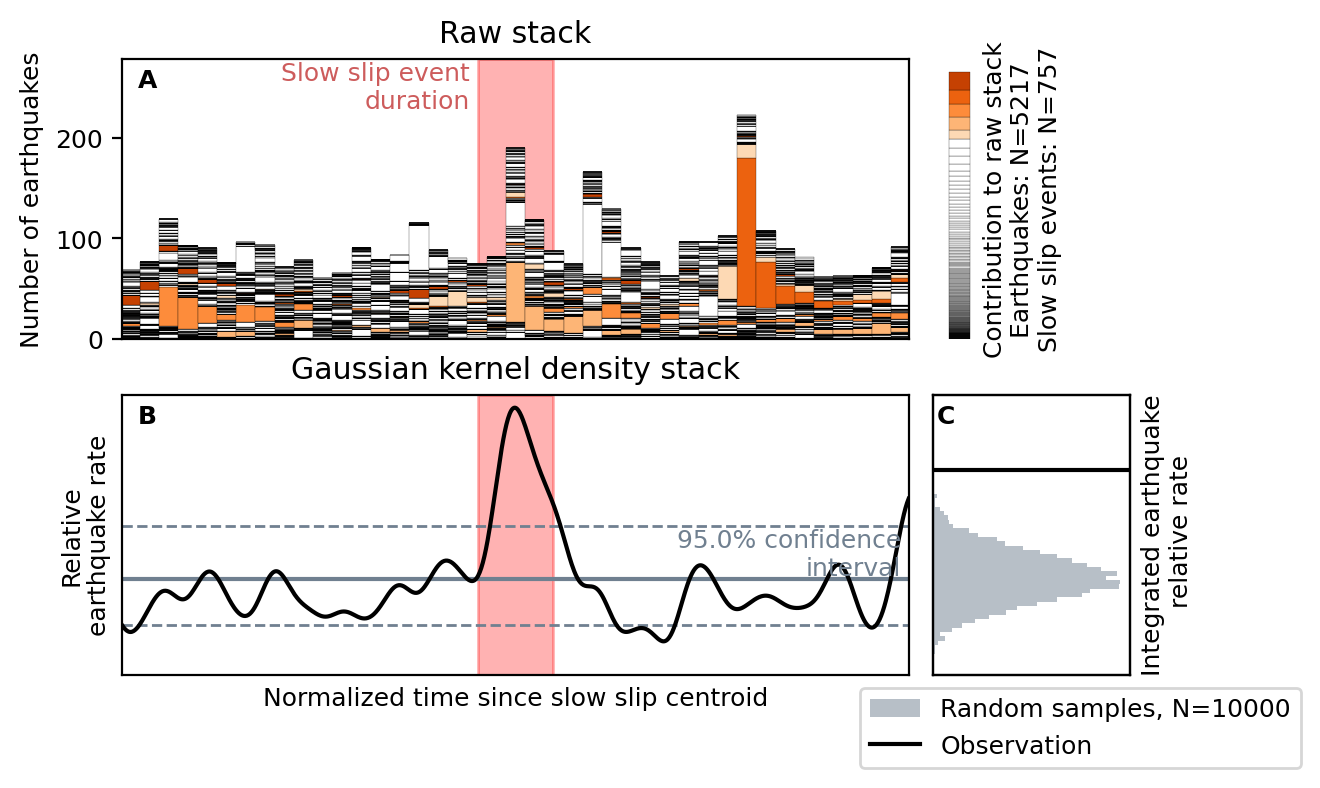

In [21]:
fig, AX = plt.subplots(2,2, figsize=(6.5,4),gridspec_kw=dict(wspace=0.05, width_ratios=[0.8,0.2]))

# Share x-axis for the first column of plots
AX[0, 0].sharex(AX[1, 0])

# Share y-axis for the second row of plots
AX[1, 0].sharey(AX[1, 1])

ax = AX[0,0]
ax.axvspan(-0.5,0.5,color='r',alpha=0.3)

number_of_eq_in_window = [len(w) for w in raw_global_relative_times]
sorted_I = np.argsort(number_of_eq_in_window)
colors = ['white']*(len(raw_global_relative_times))

num_big = 5
big_colors = plt.get_cmap('Oranges')(np.linspace(0.2,0.8,num_big))
for i_color, i_index in enumerate(sorted_I[-num_big:]):
    colors[i_index] = big_colors[i_color]

hist_info = ax.hist(
    raw_global_relative_times,
    51,
    density=False,
    histtype='barstacked',
    linewidth=0.1,
    color=colors,
    edgecolor='k',
)

ax.set(
    xticks=[],
    ylabel='Number of earthquakes',
    title='Raw stack',
)
ax.text(-0.6, 0.99*ax.get_ylim()[1], "Slow slip event\nduration", ha='right', va='top',c='indianred')

axb = ax.inset_axes([1.05, 0, 0.03, 1])
axb.set_yticks([])
axc = axb.twinx()
axc.hist([raw_global_relative_times[i] for i in sorted_I],
    1,
    density=False,
    histtype='barstacked',
    linewidth=0.1,
    color=[colors[i] for i in sorted_I],
    edgecolor='k',
)
axc.set(
    ylabel=f'Contribution to raw stack\nEarthquakes: N={len(np.concatenate(raw_global_relative_times))}\nSlow slip events: N={len(raw_global_relative_times)}',
    yticks=[],
    xticks=[],
)

for iax in [axb,axc]:
    iax.spines['top'].set_visible(False)
    iax.spines['right'].set_visible(False)
    iax.spines['bottom'].set_visible(False)
    iax.spines['left'].set_visible(False)



I = (time_array < 0.5) & (time_array>-0.5)
dt = time_array[1] - time_array[0]
null = [np.sum(ts[I])*dt for ts in random_ts]
obs = np.sum(dens_co_normalized[I]*dt)

ax = AX[1,0]
ax.axvspan(-0.5,0.5,color='r',alpha=0.3)
# for i_dens_co_normalized in random_ts:
#     ax.plot(time_array,i_dens_co_normalized, lw=1, c='slategrey', alpha=0.05)
confidence_interval = 0.95
[ax.axhline(i_null, c='slategray', ls='--',lw=1) for i_null in np.quantile(null, [(1-confidence_interval)/2, 1 - (1-confidence_interval)/2])]
ax.axhline(1, c='slategray')
ax.plot(time_array,dens_co_normalized,c='k')


ax.set(
    xlabel="Normalized time since slow slip centroid",
    ylabel='Relative\nearthquake rate',
    title='Gaussian kernel density stack',
    xlim = [-0.8*TIME_WINDOW/2,0.8*TIME_WINDOW/2]
)
ax.text(0.98 * ax.get_xlim()[1], 0.99*np.quantile(null, 0.975), f"{confidence_interval*100}% confidence\ninterval", ha='right', va='top',c='slategray')

# numeratical integratal random_ts and observation over
ax = AX[1,1]
ax.hist(null,50, orientation='horizontal', color='slategrey',alpha=0.5, density=True, label=f'Random samples, N={number_of_random_samples}')
ax.axhline(obs,c='k', label='Observation')
ax.set(
    xticks=[],
    yticks=[],
    ylim=AX[1,0].get_ylim(),
)
ax.legend(bbox_to_anchor=(0.75,0,0,0),loc='upper center')
axb = ax.twinx()
axb.set(
    ylabel="Integrated earthquake\n relative rate",
    yticks=[],
)

fig.delaxes(AX[0,1])

for n, ax in enumerate([AX[0,0],AX[1,0],AX[1,1]]):
    pos = [0.02, 0.9]
    ax.text(*pos, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')

savefig('test_of_significance')

In [91]:
signal = np.quantile(obs/null, [(1-confidence_interval)/2, 1 - (1-confidence_interval)/2])
print("Average earthquake rate during slow slip relative to background:")
print(f"{obs:0.1f} +/- {(obs-signal)[0]:0.1f}")

print(f"Percentage of random samples with a signal comparable to the observation: {np.mean(obs<null)*100}")

magnitudes_threshold_for_major_earthquake = 6.0
window_of_time_SD = 3.5
buffer = 0.5
flag_big_earthquakes = []
flag_big_prior_earthquakes = []
for window_indices, dt in zip(raw_global_Indices, raw_global_relative_times):
    
    causal = (dt>-0.5) & (dt < -0.5+window_of_time_SD)
    magnitudes = local_earthquakes.catalog.mag.values[window_indices[causal]]
    flag_big_earthquakes.append(np.any(magnitudes>magnitudes_threshold_for_major_earthquake)) 
    
    acausal = (dt<-0.5-buffer) & (dt > -0.5-buffer-window_of_time_SD)
    magnitudes = local_earthquakes.catalog.mag.values[window_indices[acausal]]   
    flag_big_prior_earthquakes.append(np.any(magnitudes>magnitudes_threshold_for_major_earthquake))    

print(
    f"{sum(flag_big_earthquakes)} of {len(flag_big_earthquakes)} ({np.mean(flag_big_earthquakes)*100:0.1f}%) slip events had an M{magnitudes_threshold_for_major_earthquake}+ earthquake during or within 3 source durations and {REPRESENTATIVE_SSE_SIZE} km"
)

print(
    f"{sum(flag_big_prior_earthquakes)} of {len(flag_big_prior_earthquakes)} ({np.mean(flag_big_prior_earthquakes)*100:0.1f}%) slow slip events had an M{magnitudes_threshold_for_major_earthquake}+ earthquake during or within 3 source durations and {REPRESENTATIVE_SSE_SIZE} km"
)

Average earthquake rate during slow slip relative to background:
1.5 +/- 0.3
Percentage of random samples with a signal comparable to the observation: 0.01
6 of 757 (0.8%) slip events had an M6.0+ earthquake during or within 3 source durations and 50 km
3 of 757 (0.4%) slow slip events had an M6.0+ earthquake during or within 3 source durations and 50 km


[(0.0, 75.0), Text(0.5, 0, '$\\Delta t / T_{SSE}$')]

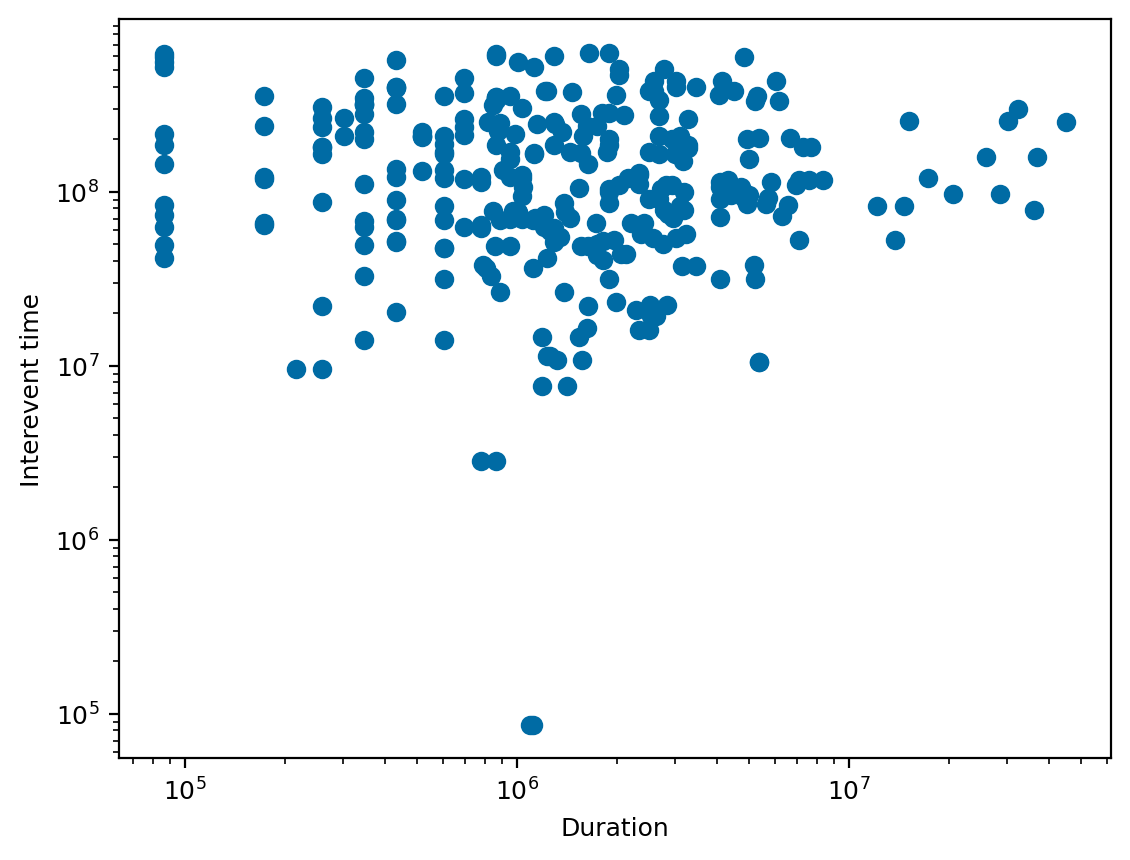

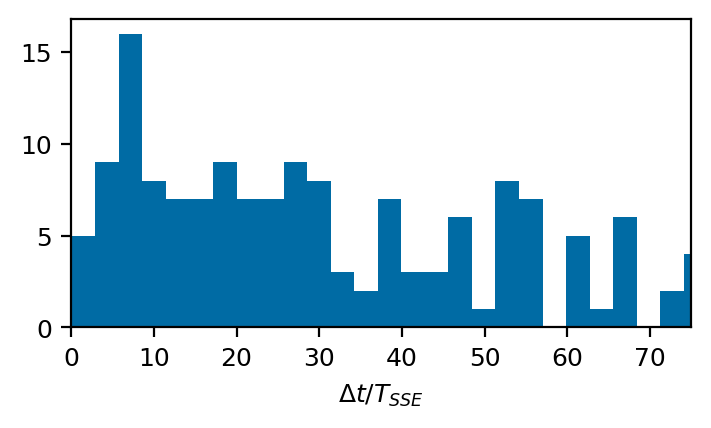

In [24]:
# for each slow slip event find event with duplicate radius that precedes it
nearby_index_list = all_slowslip.intersection(all_slowslip, 5, return_indices=True)[1]

dt = []
duration = []
for ss, i in zip(all_slowslip, nearby_index_list):
    if len(i)>1:
        t_i = ss[1].time
        t_nearby = all_slowslip[i].time
        dt.append(np.sort(np.abs((t_i-t_nearby)/ np.timedelta64(1, "s")))[1]) # technically this will double count 
        duration.append(ss[1].duration)
dt = np.array(dt)
duration = np.array(duration)

        
fig, ax = plt.subplots()
ax.scatter(duration,dt)
ax.set(
    xscale='log',
    yscale='log',
    xlabel='Duration',
    ylabel='Interevent time',
)

fig, ax = plt.subplots(figsize=(4,2))
ax.hist(dt/duration,2500)
ax.set(
    xlim=[0,75],
    xlabel=r'$\Delta t / T_{SSE}$'
)

<GeoAxes: xlabel='Longitude', ylabel='Latitude'>

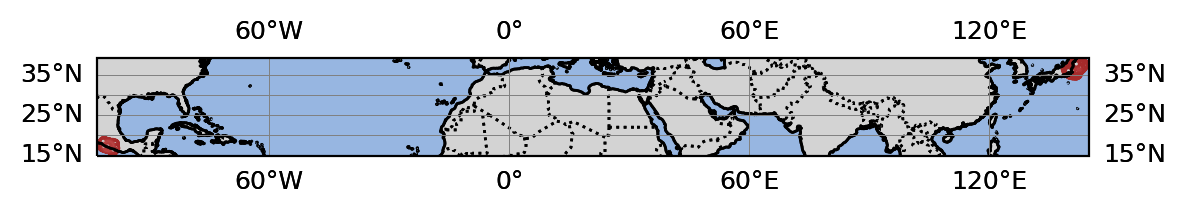

In [25]:
ss =  src.data.SlowSlipCatalog(all_slowslip[sorted_I[-4:]])
leq = local_earthquakes.intersection(ss, 200)
ax = ss.plot_map()
leq.plot_map(ax=ax)

<Axes: xlabel='Time', ylabel='mag'>

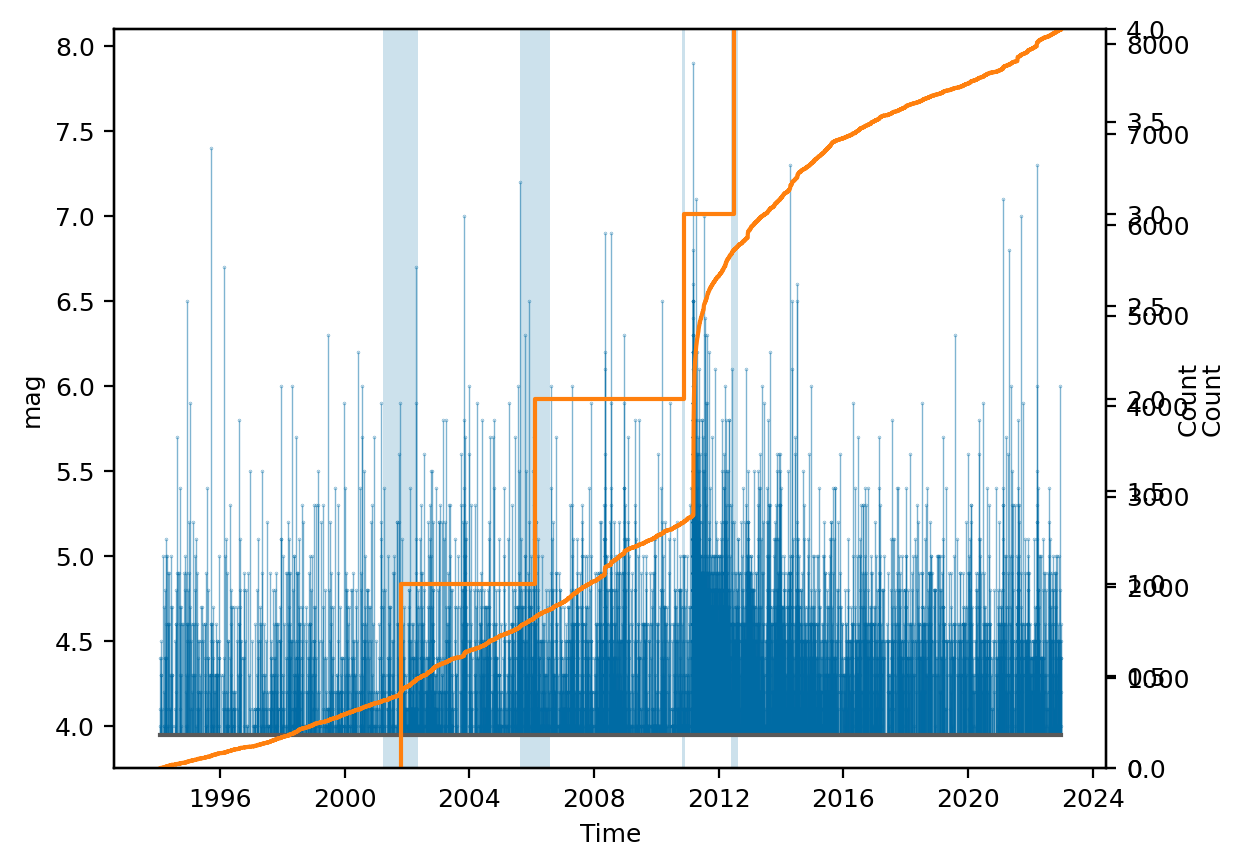

In [26]:
ax = ss.plot_slowslip_timeseries()
leq.mag_completeness = 4

leq.plot_time_series(ax=ax)

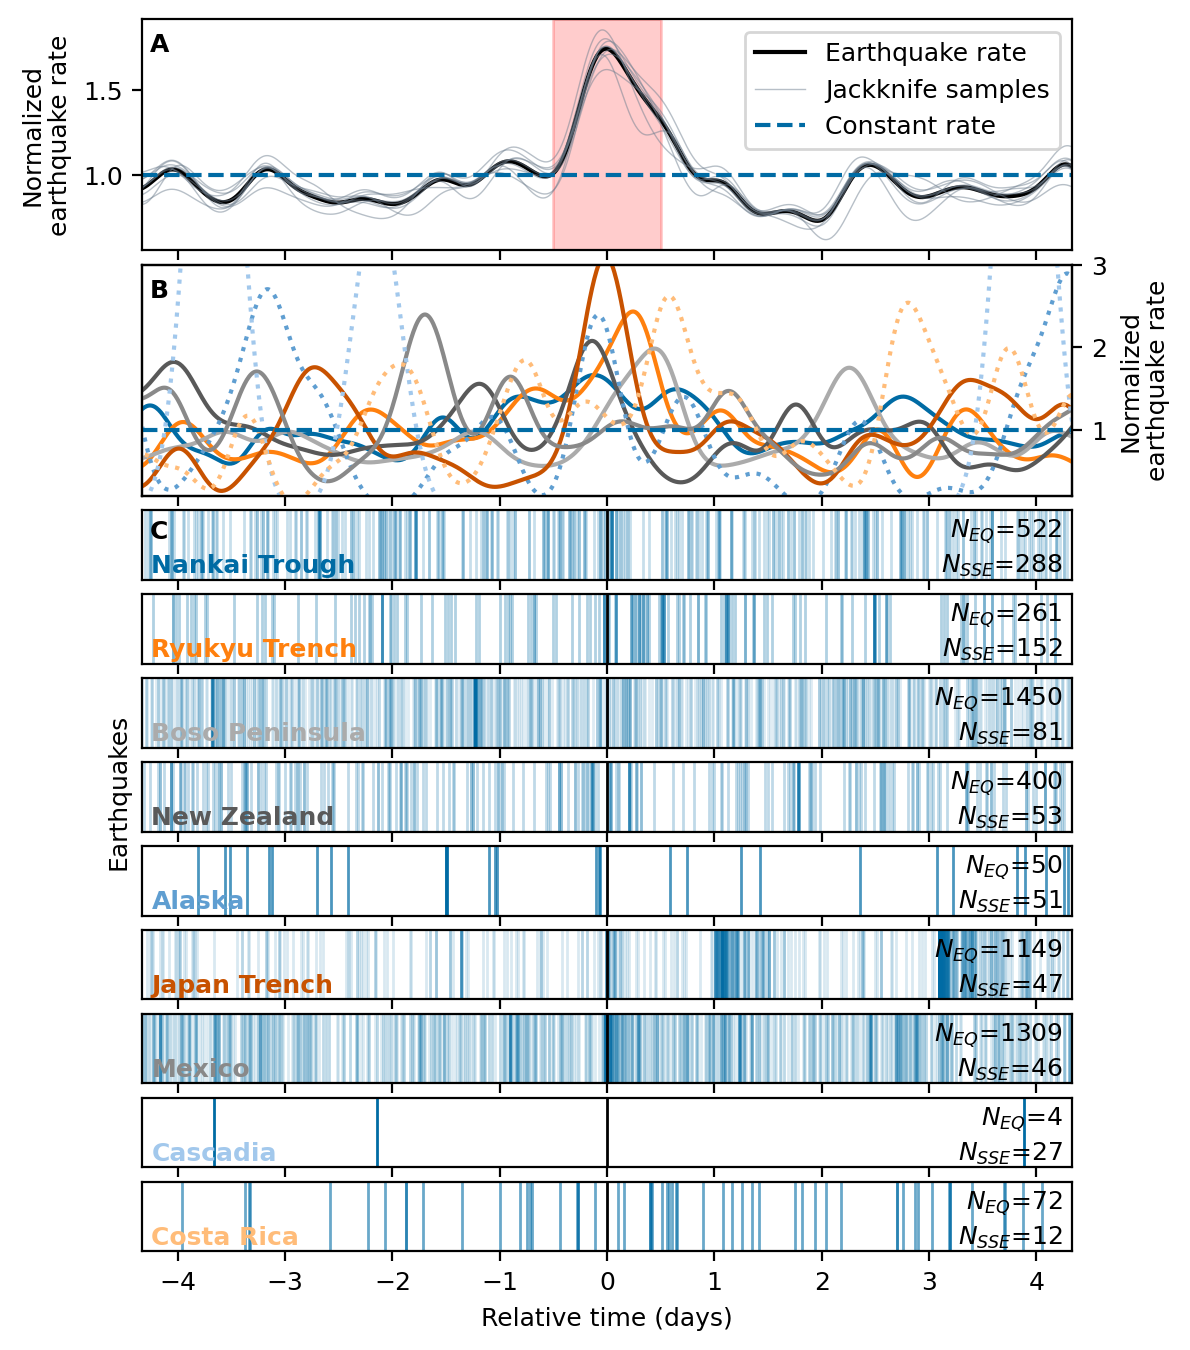

In [27]:
fig, AX = plt.subplots(
    len(slowslip)+2, 1, 
    figsize=(6,8), 
    sharex=True, 
    gridspec_kw=dict(hspace=0.15, height_ratios=2*[1]+len(slowslip)*[0.3]),
)


AX[0].axvspan(-1/2, 1/2, color='red', alpha=0.2)


AX[0].plot(
    time_array, dens_co_normalized,
    color='k',
    label='Earthquake rate'
)

lh = [
    AX[0].plot(
        time_array, regional_jackknife[i], 
        color='slategray', 
        lw=0.5, 
        alpha=0.5
    ) for i in range(len(slowslip))
]
lh[0][0].set_label('Jackknife samples')

AX[0].axhline(1,ls='--', label='Constant rate')
AX[0].legend(loc='upper right')
AX[0].set(
    ylabel='Normalized\nearthquake rate',
)

AX[1].set(yticks=[])
axb = AX[1].twinx()
for i_regional_dens, dt in zip(regional_dens, regional_relative_times):
    axb.plot(
        time_array,
        i_regional_dens,
        label=f"KDE bandwidth: {SMOOTHING_BW_SOURCE_DURATION} source durations", 
        ls=':' if len(dt)<200 else '-',
    )

axb.axhline(1,ls='--')
axb.set(
    ylim=[0.2,3],
    ylabel='Normalized\nearthquake rate',
)

for i, region, dt, i_window_indices, iax in zip(
    range(len(slowslip)), 
    slowslip, 
    regional_relative_times, 
    regional_window_indices, 
    AX[2:]
):
    sns.rugplot(
        dt, 
        ax=iax, 
        label=f'{region.name}', 
        height=1, 
        lw=0.01, 
        alpha=min(1,5/np.sqrt(len(dt))),
    ) 
    
    iax.set(
        yticks=[],
    )
    
    # iax.text(0.01,0.9,'$\chi_{SSE}$='+ f'{coupling:.2f}',transform=iax.transAxes, ha='left', va='top', color='indianred')
    iax.text(0.01,0.1,region.region,transform=iax.transAxes,color=f'C{i}', weight='bold')
    iax.text(0.99,0.1,"$N_{SSE}$" + f"={len(region)}",transform=iax.transAxes, ha='right')
    iax.text(0.99,0.9,"$N_{EQ}$" + f"={len(dt)}",transform=iax.transAxes, ha='right', va='top', color='k')
    iax.axvline(0, color='k', lw=1)


AX[-1].set(
    xlabel='Relative time (days)',
    xlim=[-TIME_WINDOW/3,TIME_WINDOW/3],
)

AX[4].set_ylabel('Earthquakes', ha='right')

for n, ax in enumerate(AX[:3]):
    pos = [0.008, 0.86]
    if n==2:
        pos = [0.008, 0.6]
    ax.text(*pos, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')

savefig('stack')



Text(0.5, 0, 'Duration (days)')

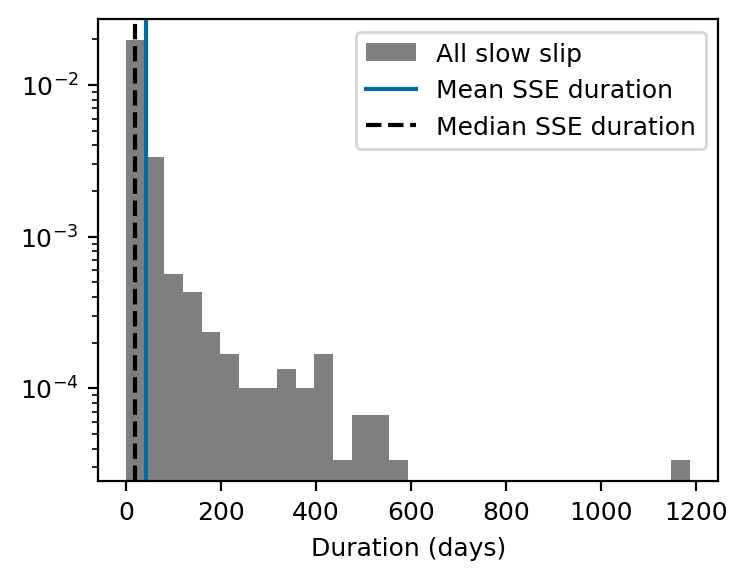

In [28]:
fig, ax = plt.subplots(figsize=(4,3))
ax.hist(all_slowslip.catalog['duration'].values/60/60/24, log=True, bins=30, color='k', alpha=0.5, density=True, label='All slow slip')
ax.axvline(np.nanmean(all_slowslip.catalog['duration'].values/60/60/24), label='Mean SSE duration')  
ax.axvline(np.nanmedian(all_slowslip.catalog['duration'].values/60/60/24),c='k',ls='--', label='Median SSE duration')
ax.legend()
ax.set_xlabel('Duration (days)')

## Spatial stacks

Text(0.5, 0, 'Estimated dimension (km)')

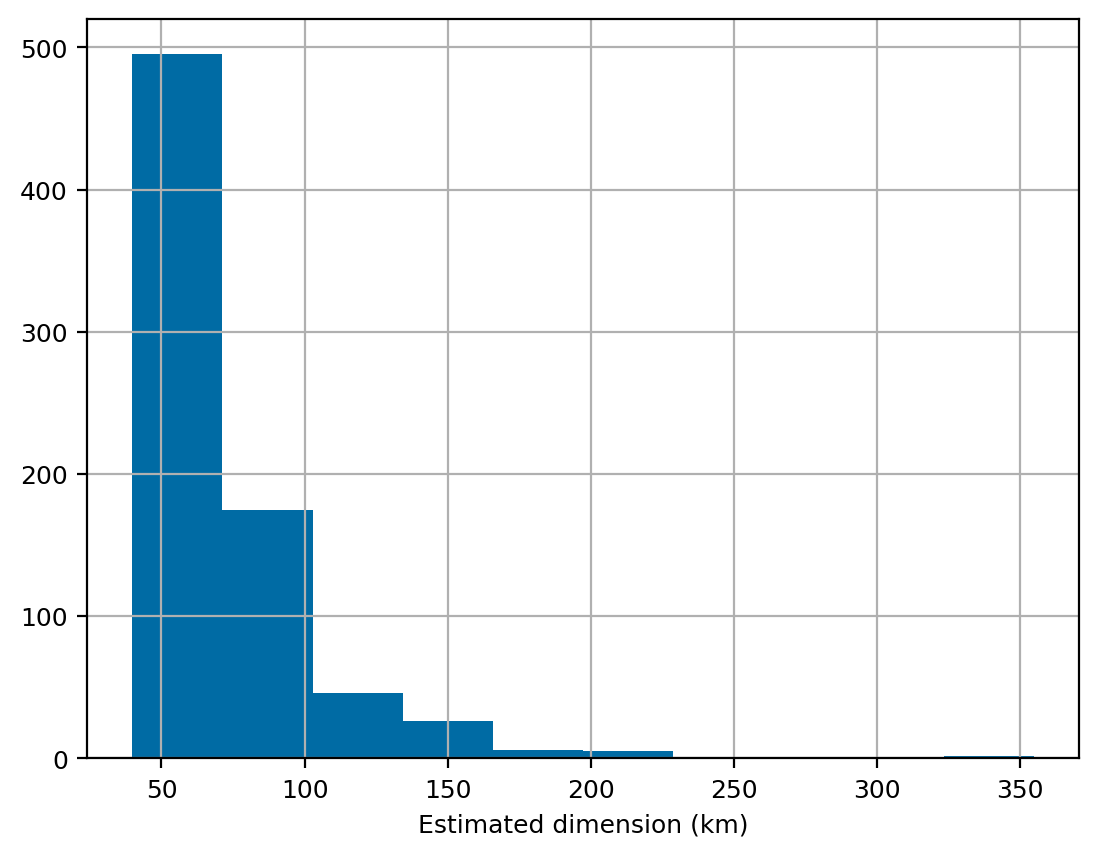

In [29]:
Scaling.magnitude_to_size(all_slowslip.catalog.mag,all_slowslip._stress_drop).hist()
plt.xlabel('Estimated dimension (km)')

In [30]:
T_pre = 5
buffer = 0.5
T_event = 1 #all_slowslip.catalog['duration'].values/60/60/24 # days
W = SPACE_WINDOW_BIG # km
number_of_source_dimensions = 3 # for visualization purposes

# small wrapper function
def center_sequences_for_spatial_analysis(T, lag): 
    stack, w = center_sequences(time_window=T,space_window=W,lag=lag)[1:]
    I = ~np.any(np.abs(stack)>number_of_source_dimensions, axis=1)
    stack = stack[I,:]
    w = w[I]
    return [stack, w]

co_event_stack_combined, co_weights = \
    center_sequences_for_spatial_analysis(T_event,0)
pre_event_stack_combined, pre_weights = \
    center_sequences_for_spatial_analysis(T_pre,-T_pre/2 - T_event/2 - buffer)
post_event_stack_combined, post_weights = \
    center_sequences_for_spatial_analysis(T_event,T_event/2 + buffer)
    

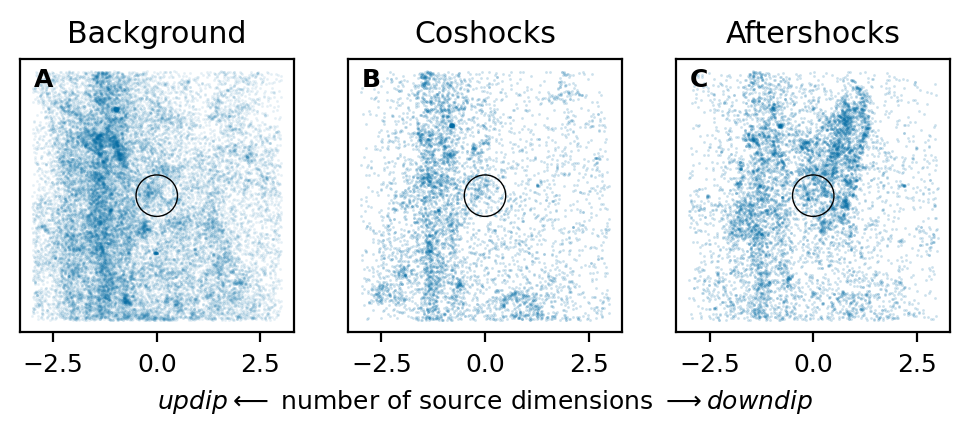

In [31]:

# Create a 2x2 grid with ratios [1, 1, 2] for the row heights
fig, AX = plt.subplots(1,3,sharex=True,sharey=True,figsize=(6,3))

levels = np.linspace(0, 0.075, 10)

# Subplot 1
ax1 = AX[0]  # First row, first column
ax1.scatter(pre_event_stack_combined[:,0], pre_event_stack_combined[:,1], s=1, alpha=0.1, linewidths=0)

# Subplot 2
ax2 = AX[1]  # Second row, first column
ax2.scatter(co_event_stack_combined[:,0], co_event_stack_combined[:,1], s=1, alpha=0.2, linewidths=0)

# Subplot 3
ax3 = AX[2]  # third row, first column
ax3.scatter(post_event_stack_combined[:,0], post_event_stack_combined[:,1], s=1, alpha=0.2, linewidths=0)

for iax,i_title in zip([ax1,ax2,ax3],['Background','Coshocks', 'Aftershocks']):
    iax.add_artist(plt.Circle((0, 0), 0.5, color='k', fill=False, lw=0.5))
    iax.set(
        aspect='equal',
        title=i_title,
    )
    
for iax in [ax2,ax3]:
    iax.set(
        yticks=[],
    )

ax2.set(
    xlabel=r'$updip \longleftarrow$ number of source dimensions $\longrightarrow downdip$',
)

for n, ax in enumerate(AX):
    pos = [0.05, 0.90]
    ax.text(*pos, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')

savefig('raw_spatial_stack')

In [32]:
# Define the bandwidth for smoothing
smoothing_bandwidth = 0.2

# Create the kernel density estimators
dens_pre_kde = gaussian_kde(pre_event_stack_combined.T, bw_method=smoothing_bandwidth/pre_event_stack_combined.T.std(ddof=1), weights=pre_weights)
dens_co_kde = gaussian_kde(co_event_stack_combined.T, bw_method=smoothing_bandwidth/co_event_stack_combined.T.std(ddof=1), weights=co_weights)
dens_post_kde = gaussian_kde(post_event_stack_combined.T, bw_method=smoothing_bandwidth/co_event_stack_combined.T.std(ddof=1), weights=post_weights)

# Define the range and grid
number_of_source_dimensions = 2
xmin, xmax = -number_of_source_dimensions, number_of_source_dimensions
ymin, ymax = -number_of_source_dimensions, number_of_source_dimensions
grid_size = 100

# Create a grid of points
xx, yy = np.meshgrid(np.linspace(xmin, xmax, grid_size), np.linspace(ymin, ymax, grid_size))
grid_points = np.column_stack((xx.flatten(), yy.flatten()))



# Evaluate the density ratio on the grid
dens_co = dens_co_kde(grid_points.T).reshape(xx.shape)
dens_pre = dens_pre_kde(grid_points.T).reshape(xx.shape)
dens_post = dens_post_kde(grid_points.T).reshape(xx.shape)
density_differences = dens_co-dens_pre
density_ratio = dens_co/dens_pre

## Ploting ratios

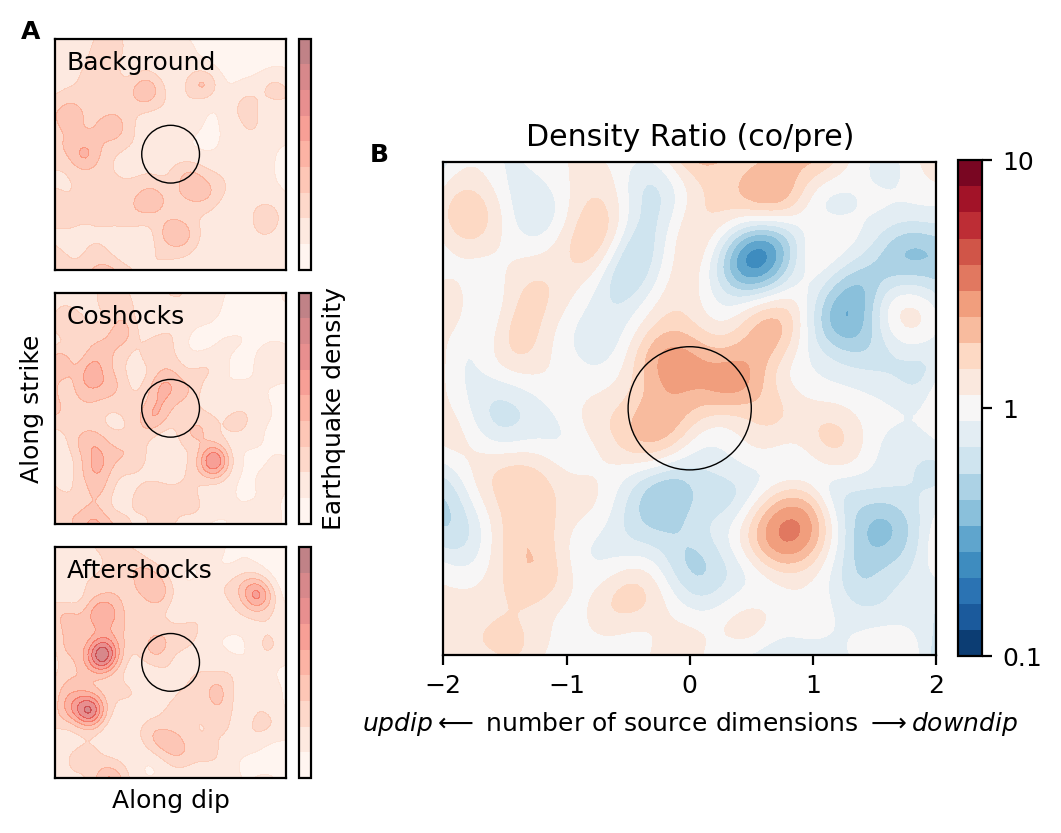

In [33]:

# Create a 2x2 grid with ratios [1, 1, 2] for the row heights
gs = mpl.gridspec.GridSpec(3, 2, width_ratios=[1.2, 2], hspace=0.1, wspace=0.3)

levels = np.linspace(0, 0.15, 10)

CH = []

# Subplot 1 - Top plot
ax1 = plt.subplot(gs[0, 0])  # First row, first column
CH.append(ax1.contourf(xx, yy, dens_pre, cmap='Reds',alpha=0.5, levels=levels))

# Subplot 2 - Middle plot
# share the x-axis with ax1
ax2 = plt.subplot(gs[1, 0], sharex=ax1)  # Second row, first column
CH.append(ax2.contourf(xx, yy, dens_co, cmap='Reds',alpha=0.5, levels=levels))

# Subplot 3 - Bottom plot
ax3 = plt.subplot(gs[2, 0])  # third row, first column
CH.append(ax3.contourf(xx, yy, dens_post, cmap='Reds',alpha=0.5, levels=levels))
ax3.set(xlabel='Along dip')


# Subplot 3 - Right plot
ax4 = plt.subplot(gs[:, 1])  # All rows, second column
ch = ax4.contourf(xx, yy, np.log10(density_ratio), levels=np.linspace(-1,1, 20), cmap='RdBu_r')
cax4 = plt.colorbar(ch, ax=ax4, fraction=0.046, pad=0.04)

cax4.set_ticks([-1, 0, 1])
cax4.set_ticklabels(['0.1', '1', '10'])

for iax in [ax1,ax2,ax3,ax4]:
    iax.add_artist(plt.Circle((0, 0), 0.5, color='k', fill=False, lw=0.5))
    iax.set(
        aspect='equal',
        xticks=[-2,-1,0,1,2],
        yticks=[-2,-1,0,1,2],
    )
    
ax4.set(
    xlabel=r'$updip \longleftarrow$ number of source dimensions $\longrightarrow downdip$',
    title='Density Ratio (co/pre)',
    yticks=[],
)
    
for iax, ich, istr in zip([ax1,ax2,ax3],CH,['Background','Coshocks','Aftershocks']):
    iax.set(
        xticks=[],
        yticks=[],
    )

    icax = plt.colorbar(ich,ax=iax,fraction=0.046, pad=0.04)
    icax.set_ticks([])
    if istr == 'Coshocks':
        iax.set(ylabel='Along strike')
        icax.set_label('Earthquake density')
    
    iax.text(0.05, 0.95, istr,
        horizontalalignment='left',
        verticalalignment='top',
        transform=iax.transAxes)
    
for n, ax in enumerate([ax1, ax4]):
    pos = [-0.15, 1]
    ax.text(*pos, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')

savefig('spatial stack')

## Frequency of anomalies

In [34]:
def get_p_relative_to_back(
    slowslipevents = all_slowslip,
    earthquakes = local_earthquakes,
    event_duration = 1,
    buffer_dutation = 0.5,
    background_duration = BACKGROUND_DURATION,
    radius_km = REPRESENTATIVE_SSE_SIZE, 
    return_time_lags = True,
    number_samples = 1000,
):

    T_event = event_duration
    buffer = buffer_dutation
    T_pre = background_duration 
    R = radius_km

    pre_time_lags, buffer_time_lags, co_time_lags = [
        center_sequences(slowslipevents, earthquakes, time_window=T,space_window=R,lag=L, concatenate_output=False)[0]
        for T, L in zip(
            [T_pre, buffer, T_event],
            [-T_pre/2 - T_event/2 - buffer, -T_event/2-buffer/2, 0],
        )
    ]

    p_values = []

    for pre, co in zip(pre_time_lags, co_time_lags):
        N_baseline = []
        
        for _ in range(number_samples):
            random_window_start_time = np.random.uniform(
                -T_pre - T_event/2 - buffer,
                -T_event/2 - buffer - T_event # -T_event because we want to avoid the event itself
            )
            
            # count number times in pre that are in the range [random_window_start_time, random_window_start_time + T_event]
            N_baseline.append(
                np.sum(
                    (pre > random_window_start_time) & (pre < random_window_start_time + T_event)
                )
            )
        eps = 0 # perturb the baseline by a small amount such that window is the same number of events are divied up equally
        p_values.append(
            np.mean(
                len(co) <= np.array(N_baseline)  + np.random.uniform(-eps,eps,len(N_baseline))
            )
        )

    p_values = np.array(p_values)
    
    if return_time_lags:
        return p_values, pre_time_lags, buffer_time_lags, co_time_lags
    else:
        return p_values

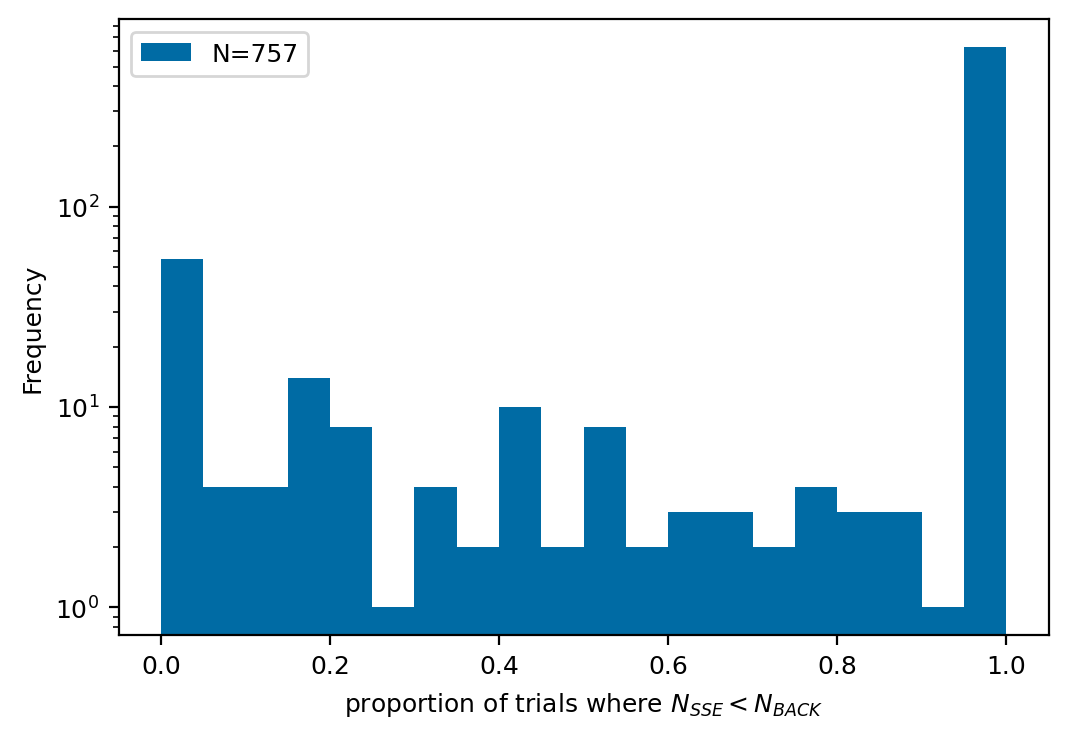

In [35]:
p_values, pre_time_lags, buffer_time_lags, co_time_lags = get_p_relative_to_back()
fig, ax = plt.subplots(1,1,figsize=(6,4))
th = 0.05
ax.hist(p_values, label=f'N={len(p_values)}', bins=20, log=True)
ax.set(xlabel='proportion of trials where $N_{SSE} < N_{BACK}$', ylabel='Frequency')
ax.legend()

Text(0.5, 0, 'number of earthquakes')

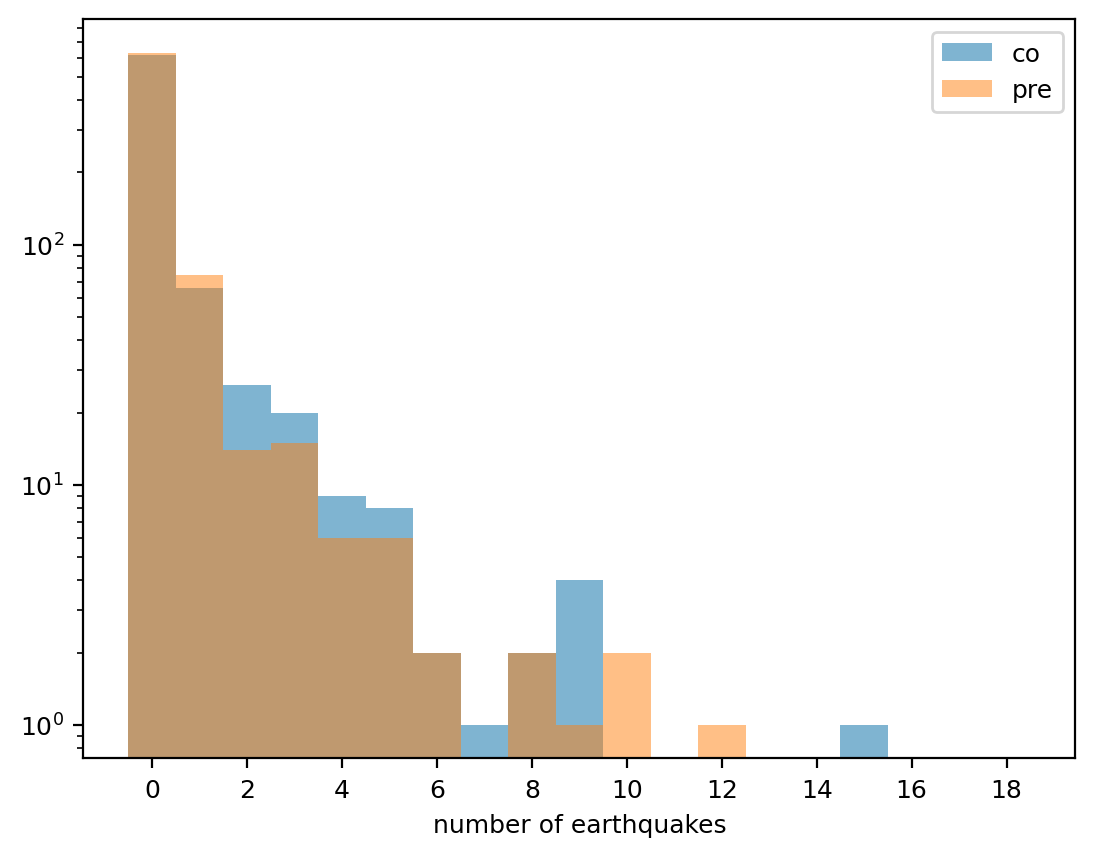

In [36]:
N = np.array([len(t) for t in co_time_lags])
N_pre = np.array([len(t) for t in pre_time_lags])
plt.hist(N,log=True, bins=np.arange(20)-0.5, alpha=0.5, label='co');
plt.hist(N_pre/BACKGROUND_DURATION,log=True, bins=np.arange(20)-0.5,alpha=0.5,label='pre');
plt.legend()
plt.xticks(np.arange(20)[::2]);
plt.xlabel('number of earthquakes')

In [37]:
(N>0).sum()/len(N)

0.18626155878467635

[None, Text(0.5, 0, '$N_{SSE} - N_{back}/L_{back}$')]

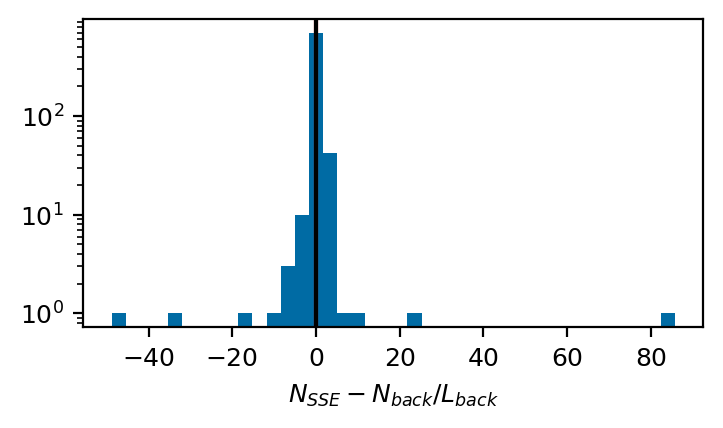

In [38]:
fig, ax = plt.subplots(figsize=(4,2))
ax.hist(N-N_pre/(BACKGROUND_DURATION), bins=40)
ax.axvline(c='r')
ax.axvline((N-N_pre/(BACKGROUND_DURATION)).mean(),c='k')
ax.set(
    yscale='log',
    xlabel=r'$N_{SSE} - N_{back}/L_{back}$'
)

In [39]:
print('Threshold: ', th)
print('Proportion of slow slip events deemed productive above threshold: ',(p_values<th).sum()/len(p_values))

Threshold:  0.05
Proportion of slow slip events deemed productive above threshold:  0.0726552179656539


In [40]:
## Look at some samples where the p-value is low - which we interpret as a significant increase in the number of events:
I = np.where(p_values < th)[0]

In [41]:
def kstest_sample(array, index):
    return kstest(np.delete(array, index), array[index])

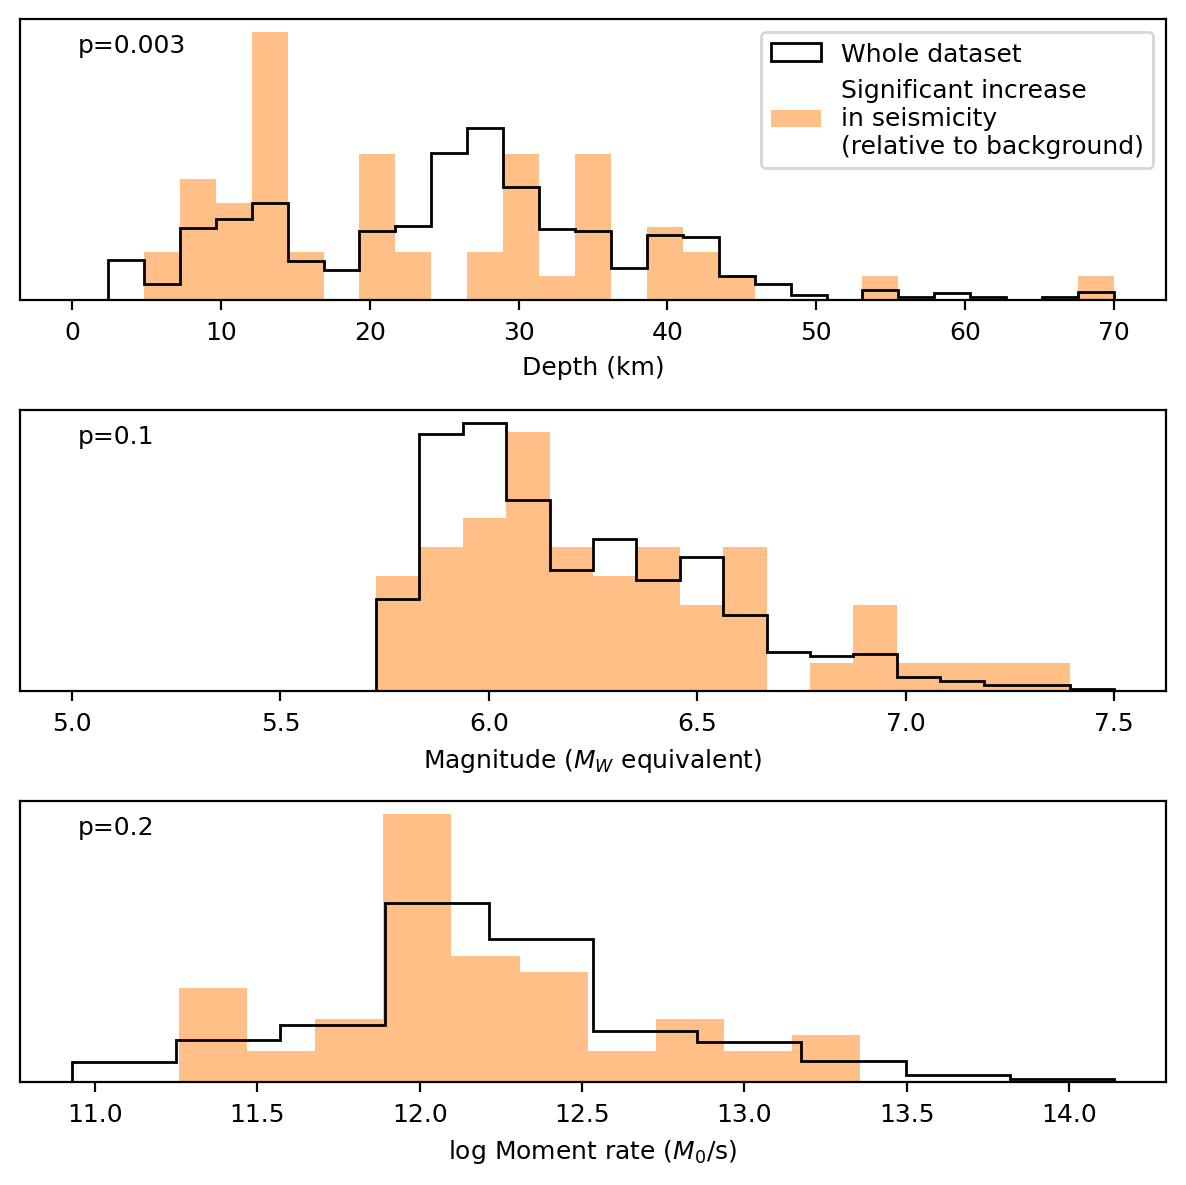

In [42]:
fig, AX = plt.subplots(3,1,figsize=(6,6))
whole_data_kwargs = dict(
    histtype='step',
    color='k',
    label='Whole dataset',
    density=True,
)
outlier_data_kwargs = dict(
     alpha=0.5, label='Significant increase\nin seismicity \n(relative to background)', color='C1',density=True,
)

ax = AX[0]
bins = np.linspace(0,70,30)
ax.hist(all_slowslip.catalog.depth.values,bins=bins, **whole_data_kwargs)
ax.hist(all_slowslip.catalog.depth.values[I], bins=bins, **outlier_data_kwargs)
# sns.rugplot(all_slowslip.catalog.depth.values[I], color='r', height=0.25, lw=0.5, ax=ax, label='Significant increase\nin seismicity \n(relative to background)')
ax.set(
    xlabel='Depth (km)',
)

ax.legend()

ax = AX[1]
bins = np.linspace(5,7.5,25)
ax.hist(all_slowslip.catalog.mag.values,bins=bins, **whole_data_kwargs)
ax.hist(all_slowslip.catalog.mag.values[I], bins=bins, **outlier_data_kwargs)
# sns.rugplot(all_slowslip.catalog.mag.values[I], color='r', height=0.25, lw=0.5, ax=ax,)
ax.set(
    xlabel='Magnitude ($M_W$ equivalent)',
)
ax = AX[2]

moment_rate = 10**(1.5*all_slowslip.catalog.mag.values + 9.1)/all_slowslip.catalog.duration.values
I_nan = (~np.isnan(moment_rate)) & (~np.isinf(moment_rate))
ax.hist(np.log10(moment_rate[I_nan]), **whole_data_kwargs)
ax.hist(np.log10(moment_rate[I][I_nan[I]]), **outlier_data_kwargs)
ax.set_xlabel('log Moment rate ($M_0$/s)')


[
    iax.text(0.05,0.95, f'p={kstest_sample(iarray,I)[1]:0.1}', transform=iax.transAxes, va='top', ha='left') 
    for iax, iarray in zip(AX, [all_slowslip.catalog.depth.values, all_slowslip.catalog.mag.values, moment_rate])
]

[iax.set_yticks([]) for iax in AX]

plt.tight_layout()
savefig('outliers')

### All places that have slow slip events seem to have some that are abnorally productive

In [43]:
number_of_slowslip_events = len(all_slowslip.catalog)
number_of_bootstrap_samples = 10000

df_groups = []
for _ in range(number_of_bootstrap_samples):
    bootstrap_sample_index = np.random.choice(
        np.arange(number_of_slowslip_events), number_of_slowslip_events, replace=True
    )
    slowslip_bootstrap_sample = all_slowslip.catalog.iloc[bootstrap_sample_index,:]
    
    productive_SSEs_bool = p_values[bootstrap_sample_index]<th
    
    
    df_groups.append(
        (
            (
                slowslip_bootstrap_sample.loc[productive_SSEs_bool,:].groupby('region').count().lat /
                slowslip_bootstrap_sample.groupby('region').count().lat
            )/(sum(productive_SSEs_bool)/len(slowslip_bootstrap_sample))
        ).fillna(0)
    )


# plt.ylabel('')
# plt.xlabel('Regional representation\nof most productive slow slip events')
# savefig('regional bias')

In [54]:
sorted_regions

region
Alaska             2
Costa Rica         3
Japan Trench       5
Mexico             5
New Zealand        6
Boso Peninsula     7
Nankai Trough     12
Ryukyu Trench     15
Name: lat, dtype: int64

In [64]:
# I hate pandas:
sorted_regions = (
    (
        all_slowslip.catalog
        .iloc[p_values<th]
        .groupby('region')
        .count().lat
        /
        all_slowslip.catalog
        .groupby('region')
        .count().lat
    )/(
        sum(p_values < th)/len(p_values))
).fillna(0).sort_values().index.values[::-1]

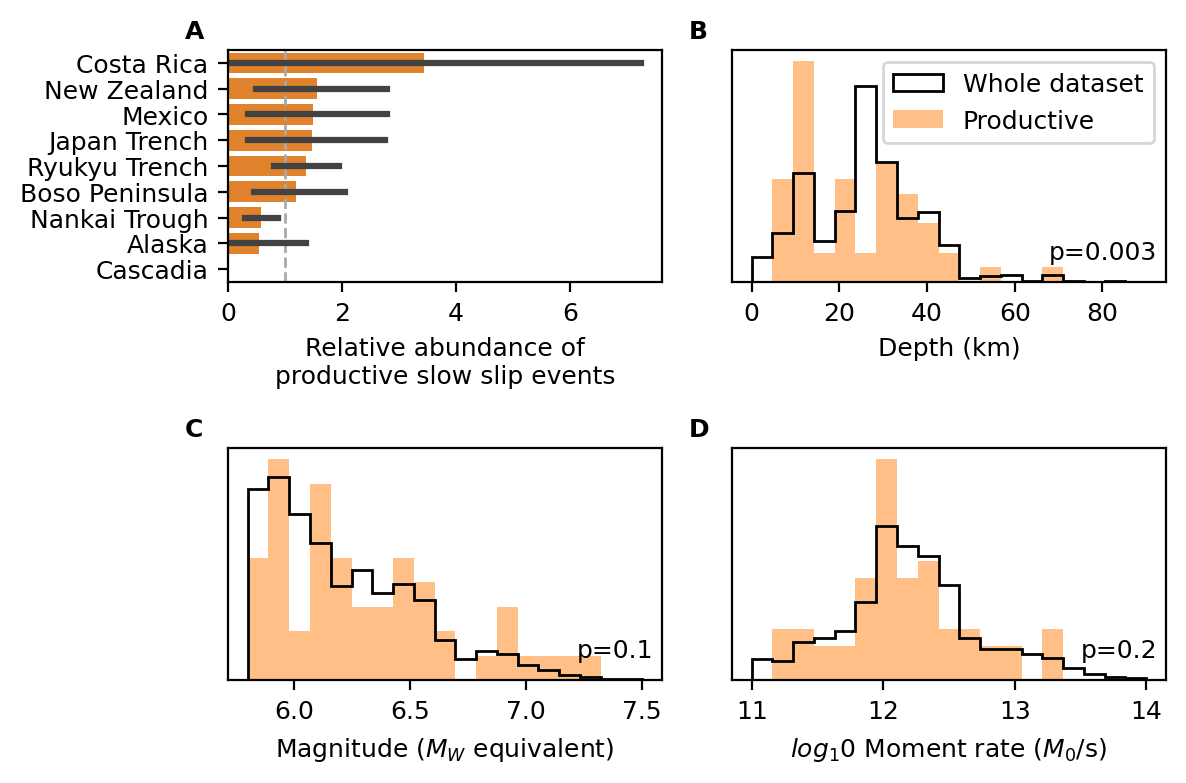

In [80]:
fig, AX = plt.subplots(2,2,figsize=(6,4))

ax = AX[0,0]

df = pd.concat([pd.DataFrame(i) for i in df_groups])
df = df.reset_index()

ax.axvline(1,c='darkgray',ls='--',lw=1)
sns.barplot(
    data=df, x='lat', y='region', 
    ax=ax, 
    order=sorted_regions, 
    color='C1', 
    errorbar = lambda x: np.quantile(x,[0.025,0.975]),
    )

ax.set(
    xlabel='Relative abundance of\nproductive slow slip events',
    ylabel='',
    xlim=[0,ax.get_xlim()[1]],
)


ax = AX[0,1]
whole_data_kwargs = dict(
    histtype='step',
    color='k',
    label='Whole dataset',
    density=True,
)
outlier_data_kwargs = dict(
     alpha=0.5, label='Productive', color='C1',density=True,
)

bins = np.linspace(0,90,20)
ax.hist(all_slowslip.catalog.depth.values,bins=bins, **whole_data_kwargs)
ax.hist(all_slowslip.catalog.depth.values[I], bins=bins, **outlier_data_kwargs)
# sns.rugplot(all_slowslip.catalog.depth.values[I], color='r', height=0.25, lw=0.5, ax=ax, label='Significant increase\nin seismicity \n(relative to background)')
ax.set(
    xlabel='Depth (km)',
)

ax.legend()


ax = AX[1,0]
bins = np.linspace(SLOWSLIP_MAGNITUDE_CUTOFF,7.5,20)
ax.hist(all_slowslip.catalog.mag.values,bins=bins, **whole_data_kwargs)
ax.hist(all_slowslip.catalog.mag.values[I], bins=bins, **outlier_data_kwargs)
# sns.rugplot(all_slowslip.catalog.mag.values[I], color='r', height=0.25, lw=0.5, ax=ax,)
ax.set(
    xlabel='Magnitude ($M_W$ equivalent)',
)
ax = AX[1,1]

moment_rate = 10**(1.5*all_slowslip.catalog.mag.values + 9.1)/all_slowslip.catalog.duration.values
I_nan = (~np.isnan(moment_rate)) & (~np.isinf(moment_rate))
bins = np.linspace(11,14,20)
ax.hist(np.log10(moment_rate[I_nan]),bins=bins, **whole_data_kwargs)
ax.hist(np.log10(moment_rate[I][I_nan[I]]),bins=bins, **outlier_data_kwargs)
ax.set_xlabel('$log_10$ Moment rate ($M_0$/s)')


[
    iax.text(0.98,0.18, f'p={kstest_sample(iarray,I)[1]:0.1}', transform=iax.transAxes, va='top', ha='right') 
    for iax, iarray in zip(AX.flatten()[1:], [all_slowslip.catalog.depth.values, all_slowslip.catalog.mag.values, moment_rate])
]

[iax.set_yticks([]) for iax in AX.flatten()[1:]]

for n, ax in enumerate(AX.flatten()):
    pos = [-0.1, 1.05]
    ax.text(*pos, string.ascii_uppercase[n], transform=ax.transAxes, weight='bold')

plt.tight_layout()


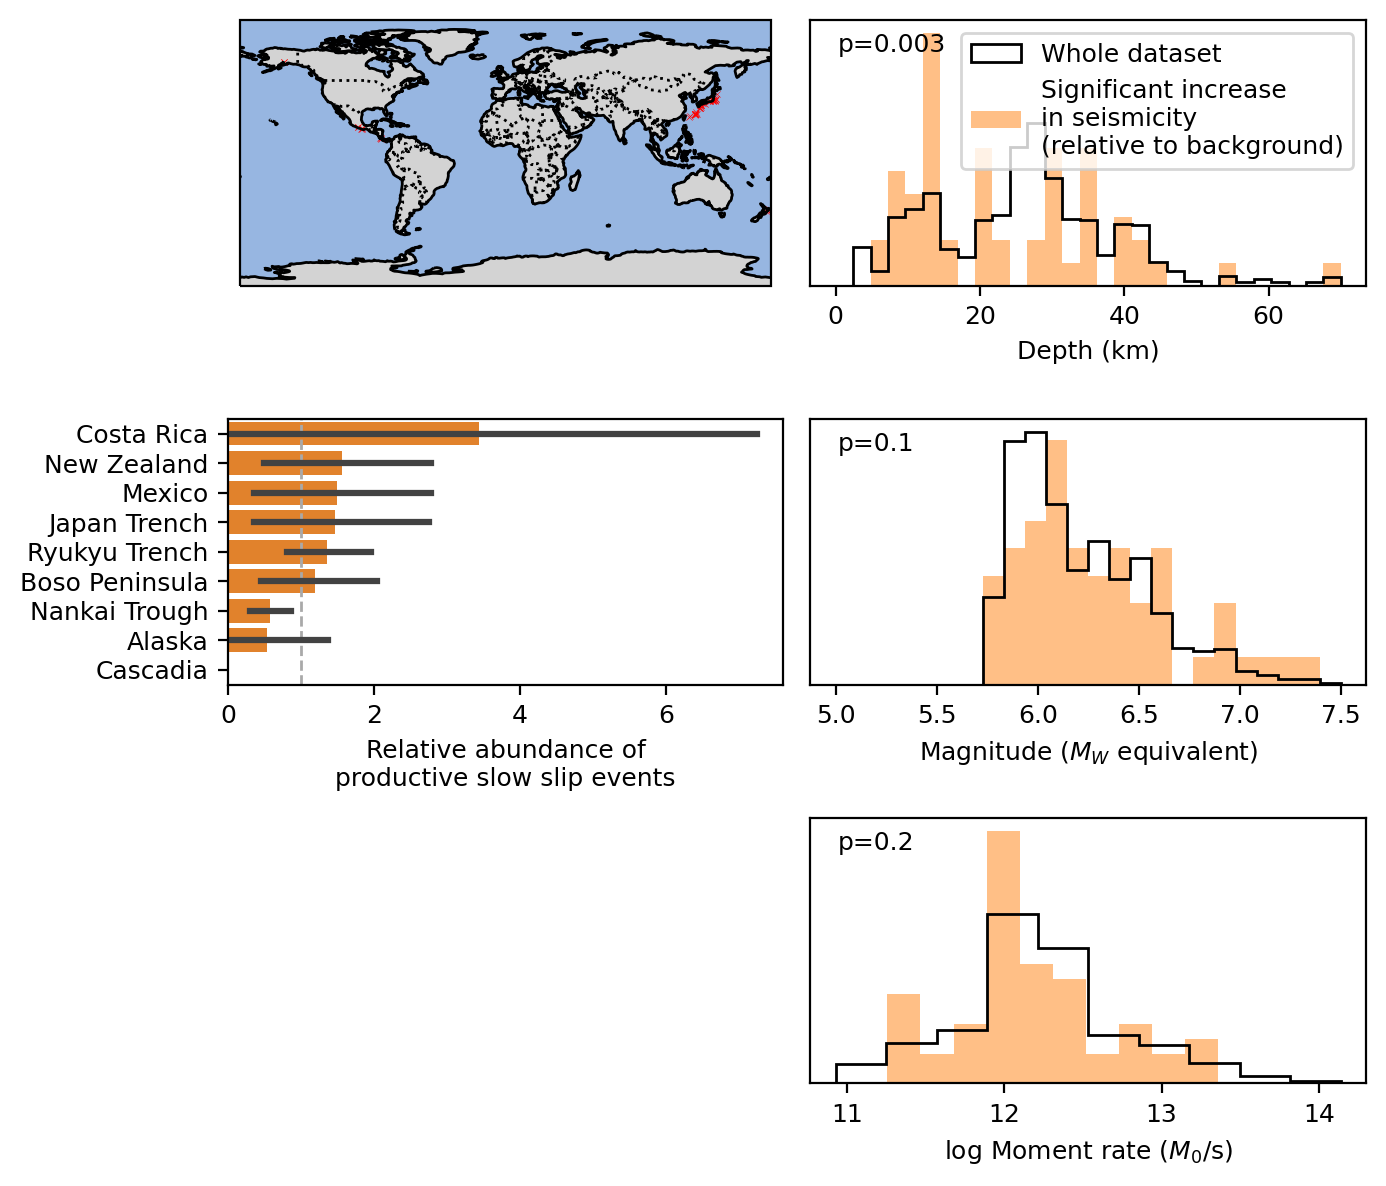

In [48]:
fig = plt.figure(figsize=(7, 6))  # Adjust the size as needed
ax = fig.add_subplot(3, 2, 1, projection=ccrs.PlateCarree())
usemap_proj = ccrs.PlateCarree()
# set appropriate extents: (lon_min, lon_max, lat_min, lat_max)
extent = [-180,180,-90,90]

ax.set_extent(
    extent,
    crs=ccrs.PlateCarree(),
)

ax.add_feature(cfeature.LAND, color="lightgray")
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=":")



ax.scatter(
    all_slowslip.catalog.lon.values[I],
    all_slowslip.catalog.lat.values[I],
    marker='x',
    s=5,
    c='r',
    linewidths=0.2,
    alpha=1,
)

ax2 = fig.add_subplot(3, 2, 3)

df = pd.concat([pd.DataFrame(i) for i in df_groups])
df = df.reset_index()

ax2.axvline(1,c='darkgray',ls='--',lw=1)
sns.barplot(
    data=df, x='lat', y='region', 
    ax=ax2, 
    order=sorted_regions, 
    color='C1', 
    errorbar = lambda x: np.quantile(x,[0.025,0.975]),
    )

ax2.set(
    xlabel='Relative abundance of\nproductive slow slip events',
    ylabel='',
    xlim=[0,ax2.get_xlim()[1]],
)


AX = [fig.add_subplot(3, 2, i) for i in [2, 4, 6]]
whole_data_kwargs = dict(
    histtype='step',
    color='k',
    label='Whole dataset',
    density=True,
)
outlier_data_kwargs = dict(
     alpha=0.5, label='Significant increase\nin seismicity \n(relative to background)', color='C1',density=True,
)

ax = AX[0]
bins = np.linspace(0,70,30)
ax.hist(all_slowslip.catalog.depth.values,bins=bins, **whole_data_kwargs)
ax.hist(all_slowslip.catalog.depth.values[I], bins=bins, **outlier_data_kwargs)
# sns.rugplot(all_slowslip.catalog.depth.values[I], color='r', height=0.25, lw=0.5, ax=ax, label='Significant increase\nin seismicity \n(relative to background)')
ax.set(
    xlabel='Depth (km)',
)

ax.legend()


ax = AX[1]
bins = np.linspace(5,7.5,25)
ax.hist(all_slowslip.catalog.mag.values,bins=bins, **whole_data_kwargs)
ax.hist(all_slowslip.catalog.mag.values[I], bins=bins, **outlier_data_kwargs)
# sns.rugplot(all_slowslip.catalog.mag.values[I], color='r', height=0.25, lw=0.5, ax=ax,)
ax.set(
    xlabel='Magnitude ($M_W$ equivalent)',
)
ax = AX[2]

moment_rate = 10**(1.5*all_slowslip.catalog.mag.values + 9.1)/all_slowslip.catalog.duration.values
I_nan = (~np.isnan(moment_rate)) & (~np.isinf(moment_rate))
ax.hist(np.log10(moment_rate[I_nan]), **whole_data_kwargs)
ax.hist(np.log10(moment_rate[I][I_nan[I]]), **outlier_data_kwargs)
ax.set_xlabel('log Moment rate ($M_0$/s)')


[
    iax.text(0.05,0.95, f'p={kstest_sample(iarray,I)[1]:0.1}', transform=iax.transAxes, va='top', ha='left') 
    for iax, iarray in zip(AX, [all_slowslip.catalog.depth.values, all_slowslip.catalog.mag.values, moment_rate])
]

[iax.set_yticks([]) for iax in AX]

plt.tight_layout()





savefig('record_map')

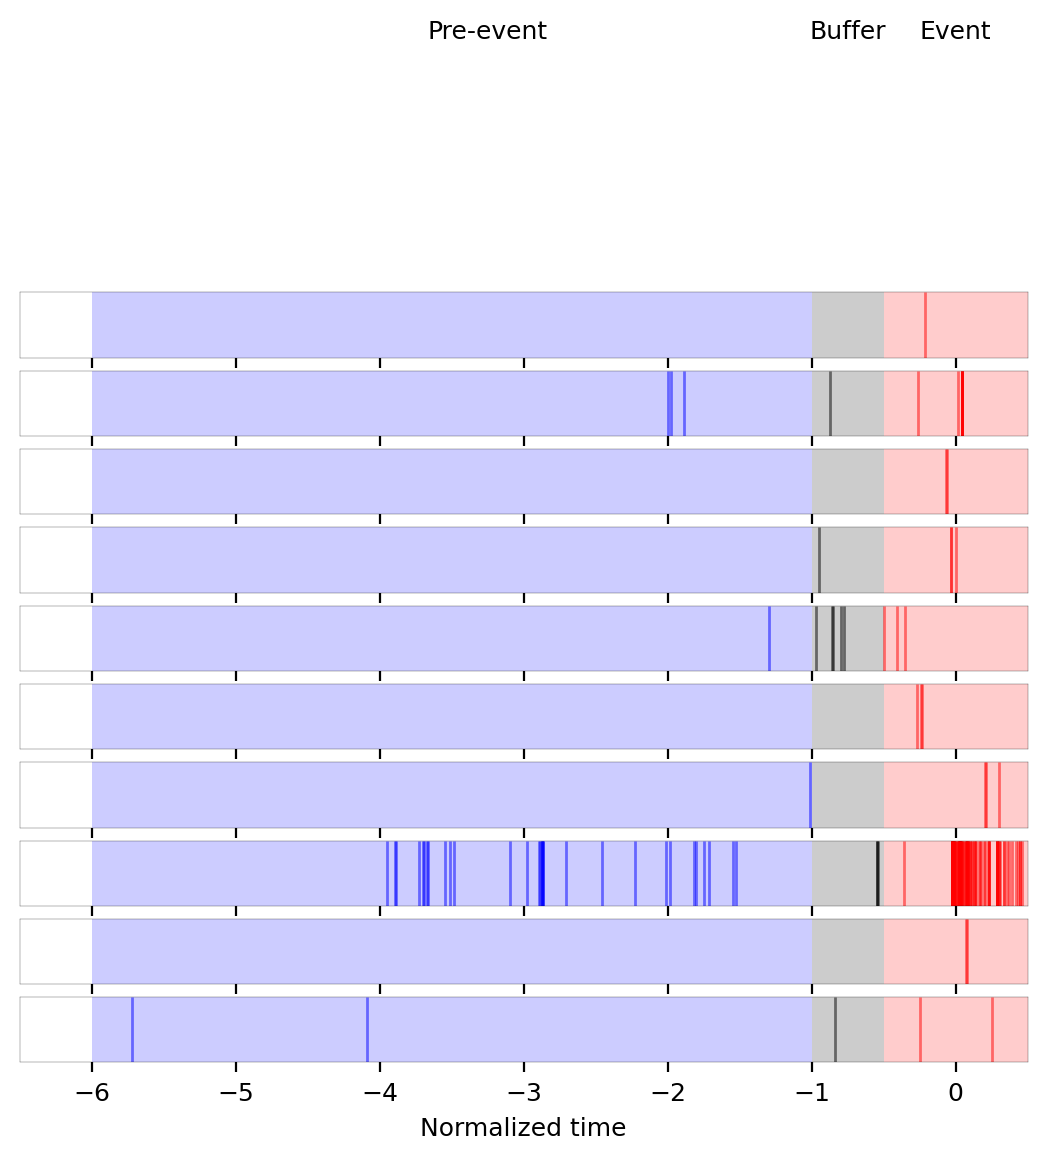

In [46]:
I = np.where(p_values<0.05)[0]
N = min(len(I),10)
t0 = -BACKGROUND_DURATION-0.5
fig, ax = plt.subplots(N,1, figsize=(6.5,5), sharex=True)
for iax,i in zip(ax,I):
    shared_kwargs = dict(height=1, alpha=0.5, ax=iax)
    [sns.rugplot(dt[i],color=c, **shared_kwargs) for dt,c in zip([pre_time_lags, buffer_time_lags, co_time_lags], ['b','k','r'])]
    
    [
        iax.axvspan(x1,x2, color=c, alpha=0.2, lw=0) 
        for x1,x2,c in zip(
            [-T_pre-buffer-T_event/2, -T_event/2-buffer, -T_event/2],
            [-T_event/2-buffer, -T_event/2, T_event/2],
            ['b','k','r'],
        )
    ]
    iax.set(yticklabels=[], xlim=[t0, T_event/2], ylabel='', yticks=[])
    
[
    ax[0].text(x,2.2, va='bottom', ha='center', s=s) for x,s in zip(
        [0, -T_event/2-buffer/2, t0/2],
        ['Event', 'Buffer', 'Pre-event']
    )
]

ax[-1].set(xlabel='Normalized time')

[[x.set_linewidth(0.1) for x in iax.spines.values()] for iax in ax];
savefig('most_triggered_earthquakes')